In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from MLib.PGM.Infections import preprocess_timeseries, beta_gamma_solver,\
    learn_beta_gamma_models, extract_data, create_SIR_data, \
    get_daily_policies, create_policy_dict, RegLinearRegression
from MLib.Learners.KerasLearner import MarkovChainRNN
from MLib.PGM.PGM import Factor, Factor_Given_Continuous, \
    compute_probability_policy_change, compute_uncertainty_given_policies,\
    check_policy_change_v3
from tensorflow.keras.preprocessing.sequence import pad_sequences
import copy
from MLib.Core.metrics import MAPE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

In [2]:
# Set the starting and ending dates for computing beta and gamma
start_dates_beta = ['2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',\
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',\
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',\
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',\
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09',\
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',\
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',\
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',\
               '2020-11-08', '2020-11-15', '2020-11-22', '2020-11-29',\
               '2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27',\
               '2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',\
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',\
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',\
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',\
               '2021-04-25']

end_dates_beta = ['2020-04-04', '2020-04-11', '2020-04-18', '2020-04-25',\
             '2020-05-02', '2020-05-09', '2020-05-16', '2020-05-23',\
             '2020-05-30', '2020-06-06', '2020-06-13', '2020-06-20',\
             '2020-06-27', '2020-07-04', '2020-07-11', '2020-07-18',\
             '2020-07-25', '2020-08-01', '2020-08-08', '2020-08-15',\
             '2020-08-22', '2020-08-29', '2020-09-05', '2020-09-12',\
             '2020-09-19', '2020-09-26', '2020-10-03', '2020-10-10',\
             '2020-10-17', '2020-10-24', '2020-10-31', '2020-11-07',\
             '2020-11-14', '2020-11-21', '2020-11-28', '2020-12-05',\
             '2020-12-12', '2020-12-19', '2020-12-26', '2021-01-02',\
             '2021-01-09', '2021-01-16', '2021-01-23', '2021-01-30',\
             '2021-02-06', '2021-02-13', '2021-02-20', '2021-02-27',\
             '2021-03-06', '2021-03-13', '2021-03-20', '2021-03-27',\
             '2021-04-03', '2021-04-10', '2021-04-17', '2021-04-24',\
             '2021-05-01']

# Set the starting and ending dates for the predictions
start_dates = ['2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',\
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',\
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',\
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09',\
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',\
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',\
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',\
               '2020-11-08', '2020-11-15', '2020-11-22', '2020-11-29',\
               '2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27',\
               '2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',\
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',\
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',\
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',\
               '2021-04-25']

end_dates = ['2020-05-02', '2020-05-09', '2020-05-16', '2020-05-23',\
             '2020-05-30', '2020-06-06', '2020-06-13', '2020-06-20',\
             '2020-06-27', '2020-07-04', '2020-07-11', '2020-07-18',\
             '2020-07-25', '2020-08-01', '2020-08-08', '2020-08-15',\
             '2020-08-22', '2020-08-29', '2020-09-05', '2020-09-12',\
             '2020-09-19', '2020-09-26', '2020-10-03', '2020-10-10',\
             '2020-10-17', '2020-10-24', '2020-10-31', '2020-11-07',\
             '2020-11-14', '2020-11-21', '2020-11-28', '2020-12-05',\
             '2020-12-12', '2020-12-19', '2020-12-26', '2021-01-02',\
             '2021-01-09', '2021-01-16', '2021-01-23', '2021-01-30',\
             '2021-02-06', '2021-02-13', '2021-02-20', '2021-02-27',\
             '2021-03-06', '2021-03-13', '2021-03-20', '2021-03-27',\
             '2021-04-03', '2021-04-10', '2021-04-17', '2021-04-24',\
             '2021-05-01']

In [3]:
# Create a dictionary with the population of the provinces
population_dict = dict()
population_dict['Alberta'] = 4.47E6
population_dict['British Columbia'] = 5.1E6
population_dict['Manitoba'] = 1.38E6
population_dict['New Brunswick'] = 775E3
population_dict['Newfoundland and Labrador']= 522E3
population_dict['Nova Scotia'] = 967E3
population_dict['Northwest Territories'] = 45E3
population_dict['Nunavut'] = 39E3 
population_dict['Ontario'] = 14.667E6
population_dict['Prince Edward Island'] = 157E3
population_dict['Quebec'] = 9.494E6
population_dict['Saskatchewan'] = 1.195E6
population_dict['Yukon'] = 41E3

all_regions = population_dict.keys()

In [4]:
# Set the path to the directory with the Oxford Policy Tracker
policy_path = './covid-policy-tracker/data/OxCGRT_latest.csv'

# Load the dataset
data = pd.read_csv(policy_path)

/home/rvega/Envs/neurips/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Estimate the betas per every day, in every province.
Params_dict = dict()

# Create a list to store a dateset with the policies and beta
country = 'Canada'
all_regions = ['Alberta', 'British Columbia', 'Manitoba', \
               'New Brunswick', 'Newfoundland and Labrador', \
               'Nova Scotia', 'Northwest Territories', \
               'Nunavut', 'Ontario', 'Prince Edward Island', \
               'Quebec', 'Saskatchewan', 'Yukon']

# Use only the features that are not constant across the entire time
policies_cardinality = {'C1_School closing':4, 'C2_Workplace closing':4, 'C3_Cancel public events':3,\
    'C4_Restrictions on gatherings':5, 'C5_Close public transport':3, 'C6_Stay at home requirements':4,\
    'C7_Restrictions on internal movement':3, 'C8_International travel controls':5, \
    'E1_Income support':3, 'E2_Debt/contract relief':3,\
    'H1_Public information campaigns':3, 'H2_Testing policy':4, 'H3_Contact tracing':3, \
    'H6_Facial Coverings':5, 'H7_Vaccination policy':6}

# Transform the daily policy into a binary vector
encoder_dict = create_policy_dict(policies_cardinality)
    
# Define the range of days to analyze, and the policies that we want
# to evaluate.
start_date = 20200327
end_date = 20210503
    
features = ['Date',\
    'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',\
    'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',\
    'C7_Restrictions on internal movement', 'C8_International travel controls', \
    'E1_Income support', 'E2_Debt/contract relief',\
    'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
    'H6_Facial Coverings', 'H7_Vaccination policy']

features = ['Date',\
    'C2_Workplace closing', 'C6_Stay at home requirements', 'C3_Cancel public events']

for region in all_regions:
    Params_dict[region] = dict()

for region in all_regions:
    Params_dict[region]['Date'] = list()
    Params_dict[region]['Beta'] = list()
    Params_dict[region]['Gamma'] = list()
    Params_dict[region]['Holidays'] = list()
    Params_dict[region]['Policy'] = list()
    Params_dict[region]['Policy_changes'] = list()
    Params_dict[region]['ICU'] = list()
    Params_dict[region]['Hospitalizations'] = list()
    Params_dict[region]['S'] = list()
    Params_dict[region]['I'] = list()
    Params_dict[region]['R'] = list()
    Params_dict[region]['Cases'] = list()
    Params_dict[region]['Deaths'] = list()
    
    # Get the data from the current region only.
    country_flag = data['CountryName'] == country
    region_flag = data['RegionName'] == region
    all_flags = np.logical_and(country_flag, region_flag)
    country_data = data.loc[all_flags, :]

    dates, processed_cases, processed_deaths, country_data_features = \
        extract_data(start_date, end_date, country_data, features)

    daily_policy = get_daily_policies(country_data_features, 
                                      features, encoder_dict)

    # -----------------------------------------------------------
    # Since the number of recovered is not in the data, assume that all the people
    # who didn't die within 15 days has recovered.
    population = population_dict[region]

    S, I, R = create_SIR_data(population, processed_cases, 
                              processed_deaths, recovery_time=14)
    
    # Load the holidays data
    holidays_data = pd.read_csv('./Holidays_dataset_Countries.csv')
    holidays_Canada = np.zeros(len(S))

    temp = list()
    for i in range(len(holidays_data)):
        for j in range(7):
            temp.append(holidays_data['Canada'].values[i])
            
    holidays_Canada[0:len(temp)] = temp
    
    for date_str, end_date_str in zip(start_dates_beta, end_dates_beta):
        date_parts = date_str.split('-')
        date = np.int32(''.join(date_parts))
        start_indx = np.where(dates == date)[0][0]
        last_indx = start_indx + 7
        
        S_train = S[start_indx-1:last_indx]
        I_train = I[start_indx-1:last_indx]
        R_train = R[start_indx-1:last_indx]

        beta, gamma = beta_gamma_solver(S_train, I_train, R_train)
            
        for j in range(last_indx - start_indx):
            Params_dict[region]['Date'].append(dates[start_indx+j])
            Params_dict[region]['Beta'].append(beta)
            Params_dict[region]['Gamma'].append(gamma)
            Params_dict[region]['Policy'].append(daily_policy[start_indx+j])
            Params_dict[region]['S'].append(S[start_indx+j])
            Params_dict[region]['I'].append(I[start_indx+j])
            Params_dict[region]['R'].append(R[start_indx+j])
            Params_dict[region]['Holidays'].append(holidays_Canada[start_indx+j])
            Params_dict[region]['Cases'].append(processed_cases[start_indx+j])
            Params_dict[region]['Deaths'].append(processed_deaths[start_indx+j])
            
    last_policy = Params_dict[region]['Policy'][0]
    weeks_since_change = 7

    Params_dict[region]['Weeks_since_change'] = list()

    for i in range(0,len(Params_dict[region]['Policy']),7):
        # Check if there is a change in policy during the current week
        c_policy = Params_dict[region]['Policy'][i+6]

        for j in range(7):
            Params_dict[region]['Weeks_since_change'].append(weeks_since_change)

        if np.sum(np.abs(c_policy - last_policy)) > 0:
            weeks_since_change = 0
            last_policy = c_policy
        else:
            if weeks_since_change < 7:
                weeks_since_change += 1


Creating encoder for C1_School closing
Creating encoder for C2_Workplace closing
Creating encoder for C3_Cancel public events
Creating encoder for C4_Restrictions on gatherings
Creating encoder for C5_Close public transport
Creating encoder for C6_Stay at home requirements
Creating encoder for C7_Restrictions on internal movement
Creating encoder for C8_International travel controls
Creating encoder for E1_Income support
Creating encoder for E2_Debt/contract relief
Creating encoder for H1_Public information campaigns
Creating encoder for H2_Testing policy
Creating encoder for H3_Contact tracing
Creating encoder for H6_Facial Coverings
Creating encoder for H7_Vaccination policy


/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
# Create the dataset for the NN-CPD
prob_tuple = np.array([
    [125, 0, 0.01, 0.98, 0.01],
    [200, 0, 0, 0.5, 0.5],
    [50, 0, 0.5, 0.5, 0],
    [125, -20, 0.5, 0.5, 0],
    [125, 20, 0, 0.5, 0.5],
    [200, 20, 0, 0.1, 0.9],
    [200, 40, 0, 0, 1],
    [50, -20, 0.9, 0.1, 0],
    [50, 20, 0, 1, 0],
    [200,-20, 0, 1, 0],
    [0, -40, 1, 0, 0],
    [250,40, 0, 0, 1]
])

In [7]:
# Train the NN-CPD
nn_model = keras.Sequential(
    [
        layers.Dense(64, activation='sigmoid', name='hidden_1'),
        layers.Dense(3, activation='softmax', name='output')
    ]
)

x = np.ones((3,2))
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction="auto", name="categorical_crossentropy"
)

optimizer_fn = tf.keras.optimizers.Adam(
    learning_rate=1E-3
)

nn_model.compile(optimizer=optimizer_fn,
              loss=loss_fn)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=1E-5, patience=30, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

nn_model.fit(prob_tuple[:,0:2], prob_tuple[:,2:], verbose=1, epochs=10000, callbacks=[early_stopping])


Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: 1.2384
Epoch 2/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.2147
Epoch 3/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.1917
Epoch 4/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.1695
Epoch 5/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.1480
Epoch 6/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.1274
Epoch 7/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.1077
Epoch 8/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.0888
Epoch 9/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.0708
Epoch 10/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.0537
Epoch 11/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.0374
Epoch 12/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.0220
Epoch 13/10000
1/1 [==================

1/1 [==============================] - 0s 2ms/step - loss: 0.5966
Epoch 103/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5936
Epoch 104/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5905
Epoch 105/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5875
Epoch 106/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.5844
Epoch 107/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5813
Epoch 108/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5782
Epoch 109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5750
Epoch 110/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5719
Epoch 111/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5687
Epoch 112/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5655
Epoch 113/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5623
Epoch 114/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.4462
Epoch 202/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4457
Epoch 203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4453
Epoch 204/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4449
Epoch 205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4444
Epoch 206/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4440
Epoch 207/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4436
Epoch 208/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4432
Epoch 209/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4428
Epoch 210/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4424
Epoch 211/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4420
Epoch 212/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4416
Epoch 213/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.4100
Epoch 302/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4097
Epoch 303/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4094
Epoch 304/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4091
Epoch 305/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4088
Epoch 306/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4085
Epoch 307/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4083
Epoch 308/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4080
Epoch 309/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4077
Epoch 310/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4074
Epoch 311/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4071
Epoch 312/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4069
Epoch 313/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3846
Epoch 402/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3843
Epoch 403/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3841
Epoch 404/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3839
Epoch 405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3837
Epoch 406/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3835
Epoch 407/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3833
Epoch 408/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3830
Epoch 409/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3828
Epoch 410/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3826
Epoch 411/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3824
Epoch 412/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3822
Epoch 413/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3654
Epoch 502/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3652
Epoch 503/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3650
Epoch 504/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3649
Epoch 505/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3647
Epoch 506/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3646
Epoch 507/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3644
Epoch 508/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3642
Epoch 509/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3641
Epoch 510/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3639
Epoch 511/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3638
Epoch 512/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3636
Epoch 513/10000
1/1 [===========

1/1 [==============================] - 0s 5ms/step - loss: 0.3506
Epoch 601/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3505
Epoch 602/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3504
Epoch 603/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3502
Epoch 604/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3501
Epoch 605/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3500
Epoch 606/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3498
Epoch 607/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3497
Epoch 608/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3495
Epoch 609/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3494
Epoch 610/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3493
Epoch 611/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3491
Epoch 612/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3374
Epoch 701/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3372
Epoch 702/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3371
Epoch 703/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3370
Epoch 704/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3368
Epoch 705/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3367
Epoch 706/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3366
Epoch 707/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3365
Epoch 708/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3363
Epoch 709/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3362
Epoch 710/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3361
Epoch 711/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3359
Epoch 712/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3267
Epoch 800/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3266
Epoch 801/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3265
Epoch 802/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3264
Epoch 803/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3263
Epoch 804/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3262
Epoch 805/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3261
Epoch 806/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3260
Epoch 807/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3259
Epoch 808/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3259
Epoch 809/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3258
Epoch 810/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3257
Epoch 811/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3180
Epoch 900/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3180
Epoch 901/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3179
Epoch 902/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3178
Epoch 903/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.3178
Epoch 904/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3177
Epoch 905/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3177
Epoch 906/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3176
Epoch 907/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3175
Epoch 908/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3174
Epoch 909/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3173
Epoch 910/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3172
Epoch 911/10000
1/1 [==========

Epoch 999/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3123
Epoch 1000/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3122
Epoch 1001/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3122
Epoch 1002/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3121
Epoch 1003/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3121
Epoch 1004/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3121
Epoch 1005/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3120
Epoch 1006/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3119
Epoch 1007/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3119
Epoch 1008/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3119
Epoch 1009/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3118
Epoch 1010/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3118
Epoch

1/1 [==============================] - 0s 4ms/step - loss: 0.3080
Epoch 1098/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3080
Epoch 1099/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3079
Epoch 1100/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3079
Epoch 1101/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3078
Epoch 1102/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3078
Epoch 1103/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3078
Epoch 1104/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3077
Epoch 1105/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3077
Epoch 1106/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3076
Epoch 1107/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3076
Epoch 1108/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3075
Epoch 1109/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.3045
Epoch 1196/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3045
Epoch 1197/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3044
Epoch 1198/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3044
Epoch 1199/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3044
Epoch 1200/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3043
Epoch 1201/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3043
Epoch 1202/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3042
Epoch 1203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3042
Epoch 1204/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3042
Epoch 1205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3042
Epoch 1206/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3041
Epoch 1207/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.3024
Epoch 1294/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3024
Epoch 1295/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3024
Epoch 1296/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3024
Epoch 1297/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3024
Epoch 1298/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3023
Epoch 1299/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3023
Epoch 1300/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3023
Epoch 1301/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3023
Epoch 1302/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3023
Epoch 1303/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3023
Epoch 1304/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 1305/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1392/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1393/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3009
Epoch 1394/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3009
Epoch 1395/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1396/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1397/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3008
Epoch 1398/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3008
Epoch 1399/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3008
Epoch 1400/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3008
Epoch 1401/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3008
Epoch 1402/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3008
Epoch 1403/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2997
Epoch 1490/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2997
Epoch 1491/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2997
Epoch 1492/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2997
Epoch 1493/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2997
Epoch 1494/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2997
Epoch 1495/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2996
Epoch 1496/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2996
Epoch 1497/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2996
Epoch 1498/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2996
Epoch 1499/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2996
Epoch 1500/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2996
Epoch 1501/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2987
Epoch 1588/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2986
Epoch 1589/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1590/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1591/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2986
Epoch 1592/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1593/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1594/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1595/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1596/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2986
Epoch 1597/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2986
Epoch 1598/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2986
Epoch 1599/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2980
Epoch 1686/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2980
Epoch 1687/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2980
Epoch 1688/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2979
Epoch 1689/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2979
Epoch 1690/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2979
Epoch 1691/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2979
Epoch 1692/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2979
Epoch 1693/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2979
Epoch 1694/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2979
Epoch 1695/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2979
Epoch 1696/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2979
Epoch 1697/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2975
Epoch 1784/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2975
Epoch 1785/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2975
Epoch 1786/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2975
Epoch 1787/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2975
Epoch 1788/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2975
Epoch 1789/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2975
Epoch 1790/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2974
Epoch 1791/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 1792/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 1793/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2974
Epoch 1794/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 1795/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1882/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1883/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2971
Epoch 1884/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2971
Epoch 1885/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1886/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1887/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1888/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1889/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1890/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1891/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1892/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 1893/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 1980/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 1981/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 1982/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 1983/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 1984/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 1985/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 1986/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 1987/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2968
Epoch 1988/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 1989/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 1990/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2968
Epoch 1991/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 2078/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 2079/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2965
Epoch 2080/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 2081/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 2082/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2965
Epoch 2083/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 2084/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 2085/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 2086/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2965
Epoch 2087/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 2088/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2965
Epoch 2089/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2176/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2177/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2178/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2179/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2963
Epoch 2180/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2181/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2182/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2963
Epoch 2183/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2184/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2185/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2186/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2187/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2274/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2275/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2276/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2277/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2278/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2279/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2961
Epoch 2280/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2281/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 2282/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 2283/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2284/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2285/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 2372/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 2373/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 2374/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 2375/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2960
Epoch 2376/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2960
Epoch 2377/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 2378/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 2379/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 2380/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 2381/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 2382/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 2383/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2470/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2471/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2472/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2473/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2474/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2475/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2476/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2477/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2478/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2479/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2480/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.2958
Epoch 2481/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 2568/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 2569/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 2570/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 2571/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2957
Epoch 2572/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 2573/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 2574/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 2575/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 2576/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 2577/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2957
Epoch 2578/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 2579/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2666/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.2956
Epoch 2667/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2668/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2669/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2670/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2671/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2672/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2673/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2674/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2675/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2676/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2677/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2764/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2765/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2766/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 2767/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2956
Epoch 2768/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2769/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2956
Epoch 2770/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2956
Epoch 2771/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2772/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2773/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2774/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 2775/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2862/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2863/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2864/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2955
Epoch 2865/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2955
Epoch 2866/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2867/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2868/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2869/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2870/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2871/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2872/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 2873/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 2960/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 2961/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 2962/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 2963/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 2964/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 2965/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 2966/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 2967/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 2968/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 2969/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 2970/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 2971/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 3058/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 3059/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 3060/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 3061/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 3062/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2954
Epoch 3063/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955


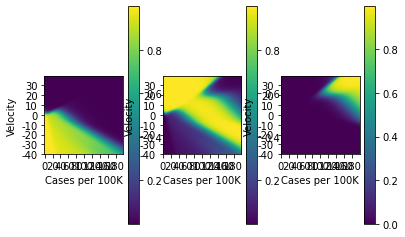

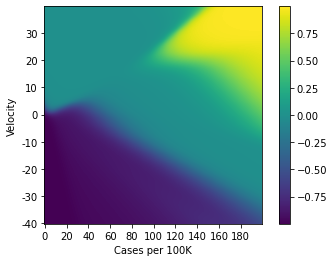

In [8]:
# Visualize the NN-CPD

cases_lin = np.linspace(0, 200, 200)
vel_lin = np.linspace(-40, 40, 200)
xy = np.meshgrid(cases_lin, vel_lin)

probabilities = np.zeros([len(cases_lin), len(vel_lin), 3])

for i in range(len(cases_lin)):
    c_tuple = np.hstack([np.reshape(xy[0][0], (-1,1)), np.reshape(xy[1][i], (-1,1))])
    prob = nn_model(c_tuple)
    probabilities[i,:,:] = prob.numpy()
    
plt.figure()

plt.subplot(1,3,1)
plt.imshow(probabilities[:,:,0], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)


plt.subplot(1,3,2)
plt.imshow(probabilities[:,:,1], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)


plt.subplot(1,3,3)
plt.imshow(probabilities[:,:,2], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)

plt.show()

new_plot = probabilities[:,:,2] + probabilities[:,:,0]*-1

plt.figure()
plt.imshow(new_plot, origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)

plt.show()

In [9]:
# Code for performing inference with PGMs
id_weeks_since_change = 1
id_openness_to_change = 2
id_change_policy = 3
id_need_to_change = 4

variables = np.array([id_openness_to_change, id_weeks_since_change])
cardinality = np.array([2, 8])
values = np.array([1, 0.9, 0.85, 0.75, 0.50, 0.25, 0, 0, 
                   0, 0.1, 0.15, 0.25, 0.50, 0.75, 1, 1])
openness_to_change = Factor(variables, cardinality, values)

variables = np.array([id_change_policy, id_openness_to_change, id_need_to_change])
cardinality = np.array([3, 2, 3])
value = np.array([
    0.02, 0.005, 0.01, 0.8, 0.09, 0.01,
    0.97, .99, 0.97, 0.19, 0.9, 0.24,
    0.01, .005, 0.02, 0.01, 0.01, 0.75
])
change_policy = Factor(variables, cardinality, value)

variables = np.array([id_need_to_change])
cardinality = np.array([3])
need_to_change = Factor_Given_Continuous(variables, cardinality, nn_model)

Factor_list = [openness_to_change, need_to_change, change_policy]

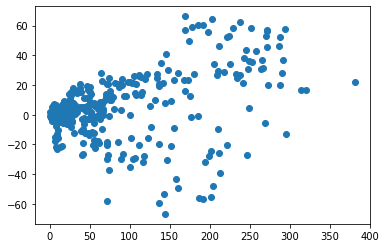

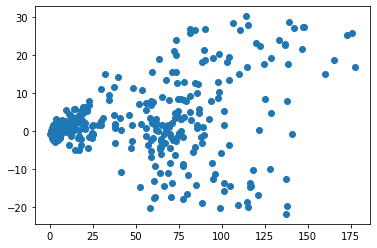

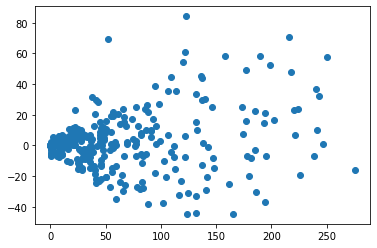

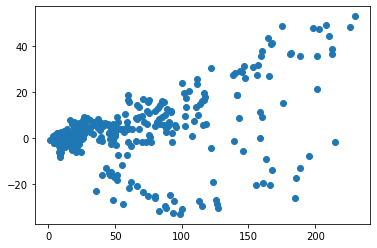

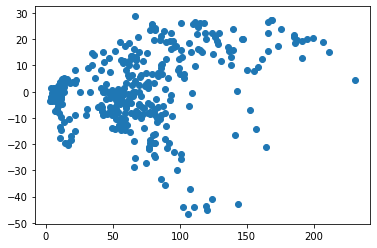

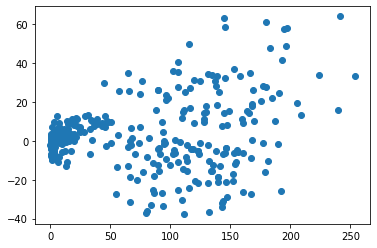

----------------------------------------------------------
Predicting 2020-04-26
Week  0

 Predicting on region  Alberta 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]

 Weeks in advance 1
Beta, Gamma
0.1 0.001
Prediction model
2516.0
Uncertainty
[0. 0. 1.]


/home/rvega/Envs/neurips/lib/python3.6/site-packages/MLib/PGM/PGM.py:176: RuntimeWarning: divide by zero encountered in log
  new_prob = np.add(np.log(factor_A.values[index_A]), np.log(factor_B.values[index_B]))


Weeks Angle Percentage
2 16.174496644295303 33.825503355704704
Predicted Policy
[0.0177594  0.97648178 0.00575881]
Real cases:  1437.0
Predicted cases:  2516.0
Mixed cases:  1671.0
Sames as last:  1671.0

 Weeks in advance 2
Beta, Gamma
0.07216336786403345 0.037734201364204294
Prediction model
2198.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 16.174496644295303 33.825503355704704
Predicted Policy
[0.0177594  0.97648178 0.00575881]
Real cases:  487.0
Predicted cases:  2198.0
Mixed cases:  1671.0
Sames as last:  1671.0

 Weeks in advance 3
Beta, Gamma
0.05903200454502417 0.010832003337196725
Prediction model
2477.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 16.174496644295303 33.825503355704704
Predicted Policy
[0.0177594  0.97648178 0.00575881]
Real cases:  430.0
Predicted cases:  2477.0
Mixed cases:  1671.0
Sames as last:  1671.0

 Weeks in advance 4
Beta, Gamma
0.043035671928606994 0.005194781378627189
Prediction model
2175.5
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 1

Week  1

 Predicting on region  Alberta 

Policy t-1 [1 0 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.04385300223342496 0.042543989898000074
Prediction model
956.5
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 -1.4317673378076066 15.190156599552573
Predicted Policy
[0.02716832 0.96656285 0.00626883]
Real cases:  487.0
Predicted cases:  956.5
Mixed cases:  956.5
Sames as last:  1437.0

 Weeks in advance 2
Beta, Gamma
0.0442322606284519 0.01705735377948283
Prediction model
1051.5
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
3 -1.4317673378076066 15.190156599552573
Predicted Policy
[0.02716832 0.96656285 0.00626883]
Real cases:  430.0
Predicted cases:  1051.5
Mixed cases:  1437.0
Sames as last:  1437.0

 Weeks in advance 3
Beta, Gamma
0.06408226426031723 0.026408537557796877
Prediction model
1795.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
3 -1.4317673378076066 15.190156599552573
Predicted Policy
[0.02716832 0.96656285 0.00626883]


Prediction model
90.375
Uncertainty
[0.3814995  0.60074933 0.01775117]
Weeks Angle Percentage
7 3.2635983263598325 3.514644351464435
Predicted Policy
[0.21491958 0.77508021 0.01000021]
Real cases:  15.0
Predicted cases:  90.375
Mixed cases:  83.83727031971182
Sames as last:  74.0
----------------------------------------------------------
Predicting 2020-05-10
Week  2

 Predicting on region  Alberta 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.023716056679457205 0.029177384108994942
Prediction model
314.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 -23.064876957494405 9.23937360178971
Predicted Policy
[0.01944834 0.97073554 0.00981612]
Real cases:  430.0
Predicted cases:  314.0
Mixed cases:  487.0
Sames as last:  487.0

 Weeks in advance 2
Beta, Gamma
0.05441546894211868 0.050646086295908
Prediction model
284.5
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 -23.064876957494405 9.23937360178971
Predicted Policy
[0.0

Prediction model
179.25
Uncertainty
[0.23455754 0.74679999 0.01864247]
Weeks Angle Percentage
7 4.602510460251045 5.2719665271966525
Predicted Policy
[0.12582372 0.8641759  0.01000038]
Real cases:  5.333333333255723
Predicted cases:  179.25
Mixed cases:  167.28629961550388
Sames as last:  132.0
----------------------------------------------------------
Predicting 2020-05-17
Week  3

 Predicting on region  Alberta 

Policy t-1 [1 0 0]
Policy t-2 [0 1 0]
Policy t-3 [1 0 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.04991920583003674 0.05147257739153681
Prediction model
318.5
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -2.4161073825503383 11.275167785234899
Predicted Policy
[0.01717203 0.97713221 0.00569576]
Real cases:  231.0
Predicted cases:  318.5
Mixed cases:  430.0
Sames as last:  430.0

 Weeks in advance 2
Beta, Gamma
0.08198883403145707 0.08418731504536865
Prediction model
244.5
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -2.4161073825503383 11.275167785234899
Pr

Prediction model
21.75
Uncertainty
[0.77625239 0.21374761 0.01      ]
Weeks Angle Percentage
7 -6.945606694560668 0.5857740585774058
Predicted Policy
[0.77625239 0.21374761 0.01      ]
Real cases:  5.333333333255723
Predicted cases:  21.75
Mixed cases:  34.52660140012787
Sames as last:  38.0

 Weeks in advance 4
Beta, Gamma
0.020328382582424035 0.022331446877360883
Prediction model
14.875
Uncertainty
[0.94217448 0.04568804 0.01213748]
Weeks Angle Percentage
7 -6.945606694560668 0.5857740585774058
Predicted Policy
[0.77625239 0.21374761 0.01      ]
Real cases:  14.0
Predicted cases:  14.875
Mixed cases:  36.943464095046245
Sames as last:  38.0
----------------------------------------------------------
Predicting 2020-05-24
Week  4

 Predicting on region  Alberta 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [1 0 0]

 Weeks in advance 1
Beta, Gamma
0.03600632526362482 0.1
Prediction model
137.5
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 -2.9530201342281863 2.

Prediction model
14.875
Uncertainty
[0.63080245 0.35919751 0.01000004]
Weeks Angle Percentage
7 -0.7531380753138075 1.7573221757322175
Predicted Policy
[0.63080245 0.35919751 0.01000004]
Real cases:  14.0
Predicted cases:  14.875
Mixed cases:  30.33436007980957
Sames as last:  39.0

 Weeks in advance 4
Beta, Gamma
0.039037512693362114 0.0672789718974762
Prediction model
7.5
Uncertainty
[0.85738512 0.12902285 0.01359203]
Weeks Angle Percentage
7 -0.7531380753138075 1.7573221757322175
Predicted Policy
[0.63080245 0.35919751 0.01000004]
Real cases:  62.0
Predicted cases:  7.5
Mixed cases:  34.935780195537646
Sames as last:  39.0
----------------------------------------------------------
Predicting 2020-05-31
Week  5

 Predicting on region  Alberta 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [1 0 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.042392868890741175 0.1
Prediction model
100.5
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -2.371364653243848 2.0357941834451903


Prediction model
4.75
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -1.9246861924686192 2.3430962343096233
Predicted Policy
[0.64043035 0.3495696  0.01000005]
Real cases:  14.0
Predicted cases:  4.75
Mixed cases:  4.75
Sames as last:  15.0

 Weeks in advance 3
Beta, Gamma
0.021815942577682542 0.0722239787438595
Prediction model
2.75
Uncertainty
[0.64043035 0.3495696  0.01000005]
Weeks Angle Percentage
7 -1.9246861924686192 2.3430962343096233
Predicted Policy
[0.64043035 0.3495696  0.01000005]
Real cases:  62.0
Predicted cases:  2.75
Mixed cases:  10.717772356379651
Sames as last:  15.0

 Weeks in advance 4
Beta, Gamma
0.020112908805747568 0.0729719147693928
Prediction model
1.25
Uncertainty
[0.86430533 0.12219891 0.01349576]
Weeks Angle Percentage
7 -1.9246861924686192 2.3430962343096233
Predicted Policy
[0.64043035 0.3495696  0.01000005]
Real cases:  51.0
Predicted cases:  1.25
Mixed cases:  13.319765018661812
Sames as last:  15.0
----------------------------------------------------

Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -0.47419804741980465 0.5857740585774058
Predicted Policy
[0.7216117  0.26838829 0.01000001]
Real cases:  14.0
Predicted cases:  1.25
Mixed cases:  1.25
Sames as last:  5.333333333255723

 Weeks in advance 2
Beta, Gamma
0.01309742108773727 0.1
Prediction model
0.875
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -0.47419804741980465 0.5857740585774058
Predicted Policy
[0.7216117  0.26838829 0.01000001]
Real cases:  62.0
Predicted cases:  0.875
Mixed cases:  0.875
Sames as last:  5.333333333255723

 Weeks in advance 3
Beta, Gamma
0.0132491724486237 0.1
Prediction model
0.375
Uncertainty
[0.7216117  0.26838829 0.01000001]
Weeks Angle Percentage
7 -0.47419804741980465 0.5857740585774058
Predicted Policy
[0.7216117  0.26838829 0.01000001]
Real cases:  51.0
Predicted cases:  0.375
Mixed cases:  4.002574735124042
Sames as last:  5.333333333255723

 Weeks in advance 4
Beta, Gamma
0.012125397871019334 0.0930558713051576
Prediction model
0.0
Uncer

Prediction model
13.125
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 0.47419804741980465 0.5857740585774058
Predicted Policy
[0.6999569  0.29004308 0.01000002]
Real cases:  62.0
Predicted cases:  13.125
Mixed cases:  13.125
Sames as last:  14.0

 Weeks in advance 2
Beta, Gamma
0.08187943973241184 0.1
Prediction model
10.25
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
7 0.47419804741980465 0.5857740585774058
Predicted Policy
[0.6999569  0.29004308 0.01000002]
Real cases:  51.0
Predicted cases:  10.25
Mixed cases:  14.0
Sames as last:  14.0

 Weeks in advance 3
Beta, Gamma
0.1 0.1
Prediction model
12.25
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
7 0.47419804741980465 0.5857740585774058
Predicted Policy
[0.6999569  0.29004308 0.01000002]
Real cases:  22.0
Predicted cases:  12.25
Mixed cases:  14.0
Sames as last:  14.0

 Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
12.25
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
7 0.47419804741980465 0.5857740585774058
Predicted Polic

Prediction model
589.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
2 -4.04465978512745 9.142616389298505
Predicted Policy
[0.04762611 0.94555887 0.00681502]
Real cases:  893.0
Predicted cases:  589.0
Mixed cases:  850.0
Sames as last:  850.0

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.1 0.1
Prediction model
53.375
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 3.2635983263598325 5.857740585774058
Predicted Policy
[0.00583268 0.98888976 0.00527757]
Real cases:  51.0
Predicted cases:  53.375
Mixed cases:  62.0
Sames as last:  62.0

 Weeks in advance 2
Beta, Gamma
0.031616290992995615 0.058132618843245394
Prediction model
27.25
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 3.2635983263598325 5.857740585774058
Predicted Policy
[0.00583268 0.98888976 0.00527757]
Real cases:  22.0
Predicted cases:  27.25
Mixed cases:  62.0
Sames as last:  62.0

 Weeks in advance 3
Beta, Gamma
0.0619

Prediction model
406.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
3 -2.9202654307983975 7.643423916859772
Predicted Policy
[0.08146799 0.91118468 0.00734732]
Real cases:  893.0
Predicted cases:  406.0
Mixed cases:  586.4166666660458
Sames as last:  586.4166666660458

 Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
406.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
3 -2.9202654307983975 7.643423916859772
Predicted Policy
[0.08146799 0.91118468 0.00734732]
Real cases:  1114.0
Predicted cases:  406.0
Mixed cases:  586.4166666660458
Sames as last:  586.4166666660458

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [1 0 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.02322253157539499 0.06577093259534594
Prediction model
16.125
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 0.2510460251046025 2.928870292887029
Predicted Policy
[0.05480869 0.93749143 0.00769989]
Real cases:  22.0
Predicted cases:  16.125
Mixed cases:  51.0
Sames a

Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 1.0524190716944046 7.52053928797135
Predicted Policy
[0.00587204 0.98883727 0.00529069]
Real cases:  623.0
Predicted cases:  590.0
Mixed cases:  705.0
Sames as last:  705.0

 Weeks in advance 2
Beta, Gamma
0.07391846865819017 0.1
Prediction model
547.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 1.0524190716944046 7.52053928797135
Predicted Policy
[0.00587204 0.98883727 0.00529069]
Real cases:  893.0
Predicted cases:  547.0
Mixed cases:  705.0
Sames as last:  705.0

 Weeks in advance 3
Beta, Gamma
0.08642906011422821 0.08344915509210163
Prediction model
609.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 1.0524190716944046 7.52053928797135
Predicted Policy
[0.00587204 0.98883727 0.00529069]
Real cases:  1114.0
Predicted cases:  609.0
Mixed cases:  705.0
Sames as last:  705.0

 Weeks in advance 4
Beta, Gamma
0.1 0.09598256874127943
Prediction model
605.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 1.0524190716944046 7.52053928797

Prediction model
490.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -0.7653956885050217 6.709500737307773
Predicted Policy
[0.02852858 0.96517099 0.00630043]
Real cases:  893.0
Predicted cases:  490.0
Mixed cases:  623.0
Sames as last:  623.0

 Weeks in advance 2
Beta, Gamma
0.062155772725851585 0.0709011028473226
Prediction model
577.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -0.7653956885050217 6.709500737307773
Predicted Policy
[0.02852858 0.96517099 0.00630043]
Real cases:  1114.0
Predicted cases:  577.0
Mixed cases:  623.0
Sames as last:  623.0

 Weeks in advance 3
Beta, Gamma
0.06119671215654387 0.058602559020159296
Prediction model
602.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -0.7653956885050217 6.709500737307773
Predicted Policy
[0.02852858 0.96517099 0.00630043]
Real cases:  1044.0
Predicted cases:  602.0
Mixed cases:  623.0
Sames as last:  623.0

 Weeks in advance 4
Beta, Gamma
0.05933099552846181 0.05629769379725998
Prediction model
599.0
Uncertainty
[1. 0

Prediction model
485.0
Uncertainty
[0.30215556 0.67959881 0.01824563]
Weeks Angle Percentage
7 -0.8113451967000751 7.922547214836026
Predicted Policy
[0.16562116 0.82437783 0.01000101]
Real cases:  598.0
Predicted cases:  485.0
Mixed cases:  600.6648303236439
Sames as last:  846.0

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [1 0 0]

 Weeks in advance 1
Beta, Gamma
0.09896426926727112 0.07137266831128944
Prediction model
1136.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
2 2.022329892563725 11.64946281862229
Predicted Policy
[0.01857377 0.97564665 0.00577958]
Real cases:  1114.0
Predicted cases:  1136.0
Mixed cases:  893.0
Sames as last:  893.0

 Weeks in advance 2
Beta, Gamma
0.06530395752636584 0.06158310519684673
Prediction model
784.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
2 2.022329892563725 11.64946281862229
Predicted Policy
[0.01857377 0.97564665 0.00577958]
Real cases:  1044.0
Predicted cases:  784.0
Mixed cases: 

Prediction model
1251.0
Uncertainty
[0.01165784 0.97782669 0.01051547]
Weeks Angle Percentage
0 2.188586623031295 6.586213949682962
Predicted Policy
[0.00586159 0.9888512  0.00528721]
Real cases:  722.0
Predicted cases:  1251.0
Mixed cases:  1247.7183505637995
Sames as last:  1103.0

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.07986323810707946 0.05847828957272219
Prediction model
1190.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 2.896566252369915 12.607962923951971
Predicted Policy
[0.02698106 0.96675404 0.0062649 ]
Real cases:  1044.0
Predicted cases:  1190.0
Mixed cases:  1190.0
Sames as last:  1114.0

 Weeks in advance 2
Beta, Gamma
0.07597509245231618 0.060441775420788275
Prediction model
1286.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 2.896566252369915 12.607962923951971
Predicted Policy
[0.02698106 0.96675404 0.0062649 ]
Real cases:  909.0
Predicted cases:  1286.0
Mixed

Uncertainty
[0.04802601 0.94463526 0.00733873]
Weeks Angle Percentage
1 -2.22949478420945 5.91804731710643
Predicted Policy
[0.04802601 0.94463526 0.00733873]
Real cases:  722.0
Predicted cases:  444.0
Mixed cases:  463.1562008234374
Sames as last:  790.0

 Weeks in advance 4
Beta, Gamma
0.04407513714022481 0.05687034305425002
Prediction model
397.0
Uncertainty
[0.09339308 0.89233577 0.01427115]
Weeks Angle Percentage
1 -2.22949478420945 5.91804731710643
Predicted Policy
[0.04802601 0.94463526 0.00733873]
Real cases:  796.0
Predicted cases:  397.0
Mixed cases:  439.3120423281227
Sames as last:  790.0

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.06389672095865984 0.05960052697341329
Prediction model
972.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
4 -0.33705498209395124 10.764693490625659
Predicted Policy
[0.05565261 0.93679044 0.00755694]
Real cases:  909.0
Predicted cases:  972.0
Mixe

Prediction model
559.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
2 -0.7908911161109966 3.340833162882662
Predicted Policy
[0.08286627 0.909063   0.00807073]
Real cases:  598.0
Predicted cases:  559.0
Mixed cases:  559.0
Sames as last:  634.0

 Weeks in advance 2
Beta, Gamma
0.056482268996254886 0.054205020826564636
Prediction model
551.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
2 -0.7908911161109966 3.340833162882662
Predicted Policy
[0.08286627 0.909063   0.00807073]
Real cases:  722.0
Predicted cases:  551.0
Mixed cases:  551.0
Sames as last:  634.0

 Weeks in advance 3
Beta, Gamma
0.053265806555815746 0.07034679967183426
Prediction model
498.0
Uncertainty
[0.08286627 0.909063   0.00807073]
Weeks Angle Percentage
2 -0.7908911161109966 3.340833162882662
Predicted Policy
[0.08286627 0.909063   0.00807073]
Real cases:  796.0
Predicted cases:  498.0
Mixed cases:  510.36743263264924
Sames as last:  634.0

 Weeks in advance 4
Beta, Gamma
0.050557672430039016 0.050090880753945057
P

Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 -0.8590713847412568 5.058975932365174
Predicted Policy
[0.0906332  0.90183755 0.00752924]
Real cases:  722.0
Predicted cases:  573.0
Mixed cases:  573.0
Sames as last:  598.0

 Weeks in advance 2
Beta, Gamma
0.05966646479515011 0.07386577306883388
Prediction model
525.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 -0.8590713847412568 5.058975932365174
Predicted Policy
[0.0906332  0.90183755 0.00752924]
Real cases:  796.0
Predicted cases:  525.0
Mixed cases:  525.0
Sames as last:  598.0

 Weeks in advance 3
Beta, Gamma
0.05614151068268394 0.06559187341076608
Prediction model
452.0
Uncertainty
[0.0906332  0.90183755 0.00752924]
Weeks Angle Percentage
3 -0.8590713847412568 5.058975932365174
Predicted Policy
[0.0906332  0.90183755 0.00752924]
Real cases:  920.0
Predicted cases:  452.0
Mixed cases:  466.3317174052774
Sames as last:  598.0

 Weeks in advance 4
Beta, Gamma
0.05447051247443028 0.04824267424965896
Prediction model
426.0
Uncerta

Prediction model
682.875
Uncertainty
[0.17162625 0.80936952 0.01900423]
Weeks Angle Percentage
7 1.4492753623188381 21.30434782608696
Predicted Policy
[0.09034626 0.89964967 0.01000407]
Real cases:  148.0
Predicted cases:  682.875
Mixed cases:  592.5399830721034
Sames as last:  209.0

 Predicting on region  Ontario 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.0809649314656401 0.07406654964326231
Prediction model
761.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
4 1.077248244358084 5.154428308447536
Predicted Policy
[0.10637919 0.88571453 0.00790628]
Real cases:  796.0
Predicted cases:  761.0
Mixed cases:  761.0
Sames as last:  722.0

 Weeks in advance 2
Beta, Gamma
0.07243919047281673 0.06804061376627002
Prediction model
708.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
4 1.077248244358084 5.154428308447536
Predicted Policy
[0.10637919 0.88571453 0.00790628]
Real cases:  920.0
Predicted cases:  708.0
Mixed cases:  

Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 5.72463768115942 27.898550724637683
Predicted Policy
[0.09011747 0.89987071 0.01001182]
Real cases:  116.0
Predicted cases:  597.375
Mixed cases:  597.375
Sames as last:  279.0

 Weeks in advance 3
Beta, Gamma
0.08634580526475759 0.0400591284688765
Prediction model
804.375
Uncertainty
[0.09011747 0.89987071 0.01001182]
Weeks Angle Percentage
7 5.72463768115942 27.898550724637683
Predicted Policy
[0.09011747 0.89987071 0.01001182]
Real cases:  148.0
Predicted cases:  804.375
Mixed cases:  751.7695755022505
Sames as last:  279.0

 Weeks in advance 4
Beta, Gamma
0.0822032547563875 0.01929638656455699
Prediction model
1081.125
Uncertainty
[0.17121155 0.8097673  0.01902115]
Weeks Angle Percentage
7 5.72463768115942 27.898550724637683
Predicted Policy
[0.09011747 0.89987071 0.01001182]
Real cases:  271.0
Predicted cases:  1081.125
Mixed cases:  928.5345946702582
Sames as last:  279.0

 Predicting on region  Ontario 

Policy t-1 [0 1 0]
Policy t

Weeks Angle Percentage
7 -6.449275362318838 10.65217391304348
Predicted Policy
[0.32411658 0.66588138 0.01000204]
Real cases:  116.0
Predicted cases:  102.5
Mixed cases:  102.5
Sames as last:  143.0

 Weeks in advance 2
Beta, Gamma
0.04248290995841565 0.044029050519216364
Prediction model
123.625
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -6.449275362318838 10.65217391304348
Predicted Policy
[0.32411658 0.66588138 0.01000204]
Real cases:  148.0
Predicted cases:  123.625
Mixed cases:  123.625
Sames as last:  143.0

 Weeks in advance 3
Beta, Gamma
0.04437838618896661 0.04771241787895344
Prediction model
127.125
Uncertainty
[0.32411658 0.66588138 0.01000204]
Weeks Angle Percentage
7 -6.449275362318838 10.65217391304348
Predicted Policy
[0.32411658 0.66588138 0.01000204]
Real cases:  271.0
Predicted cases:  127.125
Mixed cases:  132.42913308752398
Sames as last:  143.0

 Weeks in advance 4
Beta, Gamma
0.04130248919118676 0.031019463435554676
Prediction model
114.625
Uncertainty
[0.539

Weeks Angle Percentage
7 5.6127450980392215 14.503267973856211
Predicted Policy
[0.09094973 0.89904851 0.01000177]
Real cases:  941.25
Predicted cases:  1253.0
Mixed cases:  1048.666666666977
Sames as last:  1048.666666666977

 Predicting on region  Manitoba 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.05882158715454176 0.04989676502170076
Prediction model
109.375
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -4.130434782608697 8.623188405797102
Predicted Policy
[0.31498168 0.67501699 0.01000133]
Real cases:  148.0
Predicted cases:  109.375
Mixed cases:  109.375
Sames as last:  116.0

 Weeks in advance 2
Beta, Gamma
0.05783199574727324 0.05385040788781144
Prediction model
112.625
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -4.130434782608697 8.623188405797102
Predicted Policy
[0.31498168 0.67501699 0.01000133]
Real cases:  271.0
Predicted cases:  112.625
Mixed cases:  112.625
Sames as last:  116.0

 Weeks in adva

Weeks Angle Percentage
0 -1.266339869281051 16.745098039215687
Predicted Policy
[0.00503909 0.98994784 0.00501307]
Real cases:  859.3333333330229
Predicted cases:  1097.5
Mixed cases:  1002.0
Sames as last:  1002.0

 Weeks in advance 3
Beta, Gamma
0.05871517816895542 0.04582502636188764
Prediction model
1069.5
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
0 -1.266339869281051 16.745098039215687
Predicted Policy
[0.00503909 0.98994784 0.00501307]
Real cases:  941.25
Predicted cases:  1069.5
Mixed cases:  1002.0
Sames as last:  1002.0

 Weeks in advance 4
Beta, Gamma
0.05310271000188821 0.040258613225713044
Prediction model
1055.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
0 -1.266339869281051 16.745098039215687
Predicted Policy
[0.00503909 0.98994784 0.00501307]
Real cases:  1353.0
Predicted cases:  1055.0
Mixed cases:  1002.0
Sames as last:  1002.0

 Predicting on region  Manitoba 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta

Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -1.2679738562091494 12.215686274509805
Predicted Policy
[0.0149023  0.97952281 0.00557488]
Real cases:  859.3333333330229
Predicted cases:  877.0
Mixed cases:  888.0
Sames as last:  888.0

 Weeks in advance 2
Beta, Gamma
0.07049553006050988 0.04878560654314869
Prediction model
910.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -1.2679738562091494 12.215686274509805
Predicted Policy
[0.0149023  0.97952281 0.00557488]
Real cases:  941.25
Predicted cases:  910.0
Mixed cases:  888.0
Sames as last:  888.0

 Weeks in advance 3
Beta, Gamma
0.07366459779775963 0.06199665424301609
Prediction model
836.5
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -1.2679738562091494 12.215686274509805
Predicted Policy
[0.0149023  0.97952281 0.00557488]
Real cases:  1353.0
Predicted cases:  836.5
Mixed cases:  888.0
Sames as last:  888.0

 Weeks in advance 4
Beta, Gamma
0.08128449503600747 0.0665146865042634
Prediction model
836.0
Uncertainty
[0. 0. 1.]
Week

Prediction model
1655.5
Uncertainty
[0.17120635 0.80976826 0.01902539]
Weeks Angle Percentage
7 1.5212527964205798 30.171513795674866
Predicted Policy
[0.09011471 0.89987125 0.01001404]
Real cases:  3936.894115115516
Predicted cases:  1655.5
Mixed cases:  1570.1176556302496
Sames as last:  1206.666666666977

 Predicting on region  British Columbia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]

 Weeks in advance 1
Beta, Gamma
0.06851598012596528 0.04771299831562523
Prediction model
890.5
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 -1.8039215686274517 16.37908496732026
Predicted Policy
[0.01816795 0.97606673 0.00576531]
Real cases:  941.25
Predicted cases:  890.5
Mixed cases:  859.3333333330229
Sames as last:  859.3333333330229

 Weeks in advance 2
Beta, Gamma
0.07016017889600552 0.060604293997065295
Prediction model
810.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 -1.8039215686274517 16.37908496732026
Predicted Policy
[0.01816795 0.97606673 0.005

Prediction model
2815.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 15.242356450410146 37.62304250559284
Predicted Policy
[0.09004259 0.89987    0.01008741]
Real cases:  2976.666666666977
Predicted cases:  2815.0
Mixed cases:  2815.0
Sames as last:  1878.25

 Weeks in advance 3
Beta, Gamma
0.0948053990705211 0.07174353520186283
Prediction model
3583.5
Uncertainty
[0.09004259 0.89987    0.01008741]
Weeks Angle Percentage
7 15.242356450410146 37.62304250559284
Predicted Policy
[0.09004259 0.89987    0.01008741]
Real cases:  3936.894115115516
Predicted cases:  3583.5
Mixed cases:  3412.7533166093476
Sames as last:  1878.25

 Weeks in advance 4
Beta, Gamma
0.09514626171584929 0.05047441715084574
Prediction model
4475.0
Uncertainty
[0.17106922 0.80976602 0.01916476]
Weeks Angle Percentage
7 15.242356450410146 37.62304250559284
Predicted Policy
[0.09004259 0.89987    0.01008741]
Real cases:  4532.0
Predicted cases:  4475.0
Mixed cases:  3981.0099019441186
Sames as last:  1878.25

 Predic

Prediction model
2677.5
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 11.407531692766582 46.87546607009695
Predicted Policy
[0.09000725 0.89971065 0.0102821 ]
Real cases:  2976.666666666977
Predicted cases:  2677.5
Mixed cases:  2677.5
Sames as last:  2399.666666666046

 Weeks in advance 2
Beta, Gamma
0.08706188731429321 0.07152364661778496
Prediction model
3322.5
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 11.407531692766582 46.87546607009695
Predicted Policy
[0.09000725 0.89971065 0.0102821 ]
Real cases:  3936.894115115516
Predicted cases:  3322.5
Mixed cases:  3322.5
Sames as last:  2399.666666666046

 Weeks in advance 3
Beta, Gamma
0.08841858324710863 0.03766060788696223
Prediction model
4161.5
Uncertainty
[0.09000725 0.89971065 0.0102821 ]
Weeks Angle Percentage
7 11.407531692766582 46.87546607009695
Predicted Policy
[0.09000725 0.89971065 0.0102821 ]
Real cases:  4532.0
Predicted cases:  4161.5
Mixed cases:  3984.8068837813335
Sames as last:  2399.666666666046

 Weeks in ad

Weeks Angle Percentage
7 11.882845188284515 21.08786610878661
Predicted Policy
[0.09016476 0.89982986 0.01000538]
Real cases:  1082.0
Predicted cases:  623.75
Mixed cases:  550.3393734133715
Sames as last:  238.0
----------------------------------------------------------
Predicting 2020-10-25
Week  26

 Predicting on region  Alberta 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.09679658298636255 0.06925616369590494
Prediction model
3925.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 9.949664429530209 76.83818046234155
Predicted Policy
[0.08834525 0.88623298 0.02542177]
Real cases:  3936.894115115516
Predicted cases:  3925.0
Mixed cases:  3925.0
Sames as last:  2976.666666666977

 Weeks in advance 2
Beta, Gamma
0.09612817767482386 0.03702362460054902
Prediction model
5160.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 9.949664429530209 76.83818046234155
Predicted Policy
[0.08834525 0.88623298 0.02542177]
Real cases

Prediction model
919.625
Uncertainty
[0.09002191 0.89979123 0.01018685]
Weeks Angle Percentage
7 7.1129707112970735 45.69037656903766
Predicted Policy
[0.09002191 0.89979123 0.01018685]
Real cases:  1082.0
Predicted cases:  919.625
Mixed cases:  863.8462959208935
Sames as last:  363.0

 Weeks in advance 4
Beta, Gamma
0.09671642570429145 0.05218385452491776
Prediction model
1306.875
Uncertainty
[0.17102284 0.80962427 0.01935289]
Weeks Angle Percentage
7 7.1129707112970735 45.69037656903766
Predicted Policy
[0.09002191 0.89979123 0.01018685]
Real cases:  1417.0
Predicted cases:  1306.875
Mixed cases:  1127.1841038244602
Sames as last:  363.0
----------------------------------------------------------
Predicting 2020-11-01
Week  27

 Predicting on region  Alberta 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.09201099009452778 0.035659052692807267
Prediction model
5230.5
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 23.741

Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 12.887029288702934 45.69037656903766
Predicted Policy
[0.09001092 0.89973049 0.01025859]
Real cases:  594.0
Predicted cases:  682.75
Mixed cases:  682.75
Sames as last:  475.0

 Weeks in advance 2
Beta, Gamma
0.09776051438991862 0.02783807901007634
Prediction model
1064.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 12.887029288702934 45.69037656903766
Predicted Policy
[0.09001092 0.89973049 0.01025859]
Real cases:  1082.0
Predicted cases:  1064.0
Mixed cases:  1064.0
Sames as last:  475.0

 Weeks in advance 3
Beta, Gamma
0.09615824293556026 0.03560540746516482
Prediction model
1626.5
Uncertainty
[0.09001092 0.89973049 0.01025859]
Weeks Angle Percentage
7 12.887029288702934 45.69037656903766
Predicted Policy
[0.09001092 0.89973049 0.01025859]
Real cases:  1417.0
Predicted cases:  1626.5
Mixed cases:  1511.039663688507
Sames as last:  475.0

 Weeks in advance 4
Beta, Gamma
0.09351965342231745 0.02774257850966153
Prediction model
2351.75

Weeks Angle Percentage
4 5.382346745312844 90.98377922898673
Predicted Policy
[0.04444778 0.91728289 0.03826933]
Real cases:  10107.629682160914
Predicted cases:  10889.0
Mixed cases:  10336.782311424697
Sames as last:  7407.0

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.09170793538599557 0.029312657096687417
Prediction model
825.5
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 6.861924686192459 67.36401673640168
Predicted Policy
[0.08956712 0.89625967 0.0141732 ]
Real cases:  1082.0
Predicted cases:  825.5
Mixed cases:  825.5
Sames as last:  594.0

 Weeks in advance 2
Beta, Gamma
0.0910420884414659 0.03486695145855121
Prediction model
1224.5
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 6.861924686192459 67.36401673640168
Predicted Policy
[0.08956712 0.89625967 0.0141732 ]
Real cases:  1417.0
Predicted cases:  1224.5
Mixed cases:  1224.5
Sames as last:  594.0

 Weeks in advance 

Uncertainty
[0.04954118 0.75899524 0.19146358]
Weeks Angle Percentage
5 18.6328207288814 106.76216557825995
Predicted Policy
[0.04954118 0.75899524 0.19146358]
Real cases:  10107.629682160914
Predicted cases:  14783.0
Mixed cases:  13442.29052265155
Sames as last:  9220.0

 Weeks in advance 4
Beta, Gamma
0.07761382114292006 0.038818118553769466
Prediction model
17894.0
Uncertainty
[0.08714269 0.57607378 0.33678353]
Weeks Angle Percentage
5 18.6328207288814 106.76216557825995
Predicted Policy
[0.04954118 0.75899524 0.19146358]
Real cases:  12013.0
Predicted cases:  17894.0
Mixed cases:  14216.863924640129
Sames as last:  9220.0

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.1 0.036543972471178625
Prediction model
1413.375
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 27.866108786610887 179.8326359832636
Predicted Policy
[0.0205048  0.32666193 0.65283327]
Real cases:  1417.0
Predicted

Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
6 -5.287550031598926 87.66589424899938
Predicted Policy
[0.08688034 0.87414947 0.03897019]
Real cases:  8740.217283438891
Predicted cases:  7749.0
Mixed cases:  7749.0
Sames as last:  8245.0

 Weeks in advance 2
Beta, Gamma
0.06371290580531354 0.045663155924099044
Prediction model
8614.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
6 -5.287550031598926 87.66589424899938
Predicted Policy
[0.08688034 0.87414947 0.03897019]
Real cases:  10107.629682160914
Predicted cases:  8614.0
Mixed cases:  8614.0
Sames as last:  8245.0

 Weeks in advance 3
Beta, Gamma
0.06412402453630843 0.04429420573878835
Prediction model
9804.0
Uncertainty
[0.08688034 0.87414947 0.03897019]
Weeks Angle Percentage
6 -5.287550031598926 87.66589424899938
Predicted Policy
[0.08688034 0.87414947 0.03897019]
Real cases:  12013.0
Predicted cases:  9804.0
Mixed cases:  9607.799020427348
Sames as last:  8245.0

 Weeks in advance 4
Beta, Gamma
0.06865460945793166 0.0540980651397

Prediction model
12247.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
6 5.56350992022908 86.95711461103157
Predicted Policy
[0.08559376 0.86355872 0.05084752]
Real cases:  15797.0
Predicted cases:  12247.0
Mixed cases:  10660.0
Sames as last:  10660.0

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.07701899269520962 0.04769526990178433
Prediction model
9824.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -0.577024610928845 109.12155045291765
Predicted Policy
[0.06787397 0.71741541 0.21471062]
Real cases:  10107.629682160914
Predicted cases:  9824.0
Mixed cases:  9824.0
Sames as last:  8740.217283438891

 Weeks in advance 2
Beta, Gamma
0.07493698968210946 0.043716136973617814
Prediction model
11663.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -0.577024610928845 109.12155045291765
Predicted Policy
[0.06787397 0.71741541 0.21471062]
Real cases:  12013.0
Predicted cases:  11663.0
Mixed c


Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.08253905912939527 0.045285547166537564
Prediction model
11945.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 13.321916121356495 138.14417290001987
Predicted Policy
[0.03307457 0.43035645 0.53656898]
Real cases:  12013.0
Predicted cases:  11945.0
Mixed cases:  11945.0
Sames as last:  10107.629682160914

 Weeks in advance 2
Beta, Gamma
0.08437562061052702 0.07002898263197052
Prediction model
14562.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 13.321916121356495 138.14417290001987
Predicted Policy
[0.03307457 0.43035645 0.53656898]
Real cases:  12918.0
Predicted cases:  14562.0
Mixed cases:  14562.0
Sames as last:  10107.629682160914

 Weeks in advance 3
Beta, Gamma
0.08301126087332077 0.05001462645910147
Prediction model
16544.0
Uncertainty
[0.03307457 0.43035645 0.53656898]
Weeks Angle Percentage
7 13.321916121356495 138.14417290001987
Predicted Policy
[0.03307457 0.430

Weeks Angle Percentage
1 5.4203313561055495 89.3911502011318
Predicted Policy
[0.01325581 0.97511283 0.01163135]
Real cases:  18587.0
Predicted cases:  14063.0
Mixed cases:  13119.0
Sames as last:  13119.0

 Weeks in advance 4
Beta, Gamma
0.0644528605868864 0.05661174264014117
Prediction model
14945.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 5.4203313561055495 89.3911502011318
Predicted Policy
[0.01325581 0.97511283 0.01163135]
Real cases:  23839.0
Predicted cases:  14945.0
Mixed cases:  13119.0
Sames as last:  13119.0

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.08810033159404815 0.0710632449951502
Prediction model
14049.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 23.95860208722482 139.94101537813356
Predicted Policy
[0.03099664 0.413215   0.55578836]
Real cases:  12918.0
Predicted cases:  14049.0
Mixed cases:  14049.0
Sames as last:  12013.0

 Weeks in advance 2
Beta, Gamma

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.07622877318400102 0.048942852390517516
Prediction model
14113.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 8.314412448271284 150.2633242047609
Predicted Policy
[0.02639635 0.37526398 0.59833967]
Real cases:  15525.0
Predicted cases:  14113.0
Mixed cases:  14113.0
Sames as last:  12918.0

 Weeks in advance 2
Beta, Gamma
0.07512847010632728 0.044140852161452006
Prediction model
16786.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 8.314412448271284 150.2633242047609
Predicted Policy
[0.02639635 0.37526398 0.59833967]
Real cases:  16956.605880215764
Predicted cases:  16786.0
Mixed cases:  16786.0
Sames as last:  12918.0

 Weeks in advance 3
Beta, Gamma
0.07836948790256851 0.05894681199893124
Prediction model
20667.0
Uncertainty
[0.02639635 0.37526398 0.59833967]
Weeks Angle Percentage
7 8.314412448271284 150.2633242047609
Predicted Policy
[0

Prediction model
23773.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 26.743206235517164 165.5993258900358
Predicted Policy
[0.02258639 0.3438342  0.63357941]
Real cases:  18798.0
Predicted cases:  23773.0
Mixed cases:  23773.0
Sames as last:  15525.0

 Weeks in advance 3
Beta, Gamma
0.08939341145339708 0.06241284131083864
Prediction model
29100.0
Uncertainty
[0.02258639 0.3438342  0.63357941]
Weeks Angle Percentage
7 26.743206235517164 165.5993258900358
Predicted Policy
[0.02258639 0.3438342  0.63357941]
Real cases:  14737.0
Predicted cases:  29100.0
Mixed cases:  20192.54931662404
Sames as last:  15525.0

 Weeks in advance 4
Beta, Gamma
0.08749111375624344 0.03513214121071694
Prediction model
34231.0
Uncertainty
[0.03035236 0.11822196 0.85142568]
Weeks Angle Percentage
7 26.743206235517164 165.5993258900358
Predicted Policy
[0.02258639 0.3438342  0.63357941]
Real cases:  11206.0
Predicted cases:  34231.0
Mixed cases:  17736.4599782372
Sames as last:  15525.0

 Predicting on region

Prediction model
23150.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 20.008488310675375 146.4293237834422
Predicted Policy
[0.02857167 0.39321017 0.57821816]
Real cases:  14737.0
Predicted cases:  23150.0
Mixed cases:  23150.0
Sames as last:  16956.605880215764

 Weeks in advance 3
Beta, Gamma
0.08398009907085094 0.04579441140198849
Prediction model
27450.0
Uncertainty
[0.02857167 0.39321017 0.57821816]
Weeks Angle Percentage
7 20.008488310675375 146.4293237834422
Predicted Policy
[0.02857167 0.39321017 0.57821816]
Real cases:  11206.0
Predicted cases:  27450.0
Mixed cases:  21082.715196972553
Sames as last:  16956.605880215764

 Weeks in advance 4
Beta, Gamma
0.08105142304170358 0.04375507540237388
Prediction model
30750.0
Uncertainty
[0.03980634 0.15461424 0.80557942]
Weeks Angle Percentage
7 20.008488310675375 146.4293237834422
Predicted Policy
[0.02857167 0.39321017 0.57821816]
Real cases:  9184.0
Predicted cases:  30750.0
Mixed cases:  19089.261030689573
Sames as last:  16956.

Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 4.638657254945002 230.55614072045503
Predicted Policy
[0.01587935 0.28850312 0.69561753]
Real cases:  14737.0
Predicted cases:  21870.0
Mixed cases:  21870.0
Sames as last:  18798.0

 Weeks in advance 2
Beta, Gamma
0.08366774541186991 0.04573959829351321
Prediction model
25803.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
7 4.638657254945002 230.55614072045503
Predicted Policy
[0.01587935 0.28850312 0.69561753]
Real cases:  11206.0
Predicted cases:  25803.0
Mixed cases:  18798.0
Sames as last:  18798.0

 Weeks in advance 3
Beta, Gamma
0.058312496036100656 0.04774519459008074
Prediction model
17891.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
7 4.638657254945002 230.55614072045503
Predicted Policy
[0.01587935 0.28850312 0.69561753]
Real cases:  9184.0
Predicted cases:  17891.0
Mixed cases:  18798.0
Sames as last:  18798.0

 Weeks in advance 4
Beta, Gamma
0.06250494217176449 0.04685938875385551
Prediction model
20862.0
Uncertainty
[0. 

Prediction model
15559.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
0 -21.25552980829997 164.05097956604172
Predicted Policy
[0.00899853 0.97400591 0.01699556]
Real cases:  9184.0
Predicted cases:  15559.0
Mixed cases:  14737.0
Sames as last:  14737.0

 Weeks in advance 3
Beta, Gamma
0.06871246403879536 0.05237893425317895
Prediction model
14195.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
0 -21.25552980829997 164.05097956604172
Predicted Policy
[0.00899853 0.97400591 0.01699556]
Real cases:  7617.0
Predicted cases:  14195.0
Mixed cases:  14737.0
Sames as last:  14737.0

 Weeks in advance 4
Beta, Gamma
0.07411192599602155 0.05553885589271279
Prediction model
14203.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
0 -21.25552980829997 164.05097956604172
Predicted Policy
[0.00899853 0.97400591 0.01699556]
Real cases:  6903.0
Predicted cases:  14203.0
Mixed cases:  14737.0
Sames as last:  14737.0

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [

Beta, Gamma
0.07433393455257238 0.0555759657923014
Prediction model
9762.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -41.00484516536761 124.23635980619339
Predicted Policy
[0.01261477 0.95969945 0.02768577]
Real cases:  7617.0
Predicted cases:  9762.0
Mixed cases:  11206.0
Sames as last:  11206.0

 Weeks in advance 3
Beta, Gamma
0.1 0.07195798488687705
Prediction model
8218.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -41.00484516536761 124.23635980619339
Predicted Policy
[0.01261477 0.95969945 0.02768577]
Real cases:  6903.0
Predicted cases:  8218.0
Mixed cases:  11206.0
Sames as last:  11206.0

 Weeks in advance 4
Beta, Gamma
0.1 0.08809779999805033
Prediction model
7814.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -41.00484516536761 124.23635980619339
Predicted Policy
[0.01261477 0.95969945 0.02768577]
Real cases:  5576.0
Predicted cases:  7814.0
Mixed cases:  11206.0
Sames as last:  11206.0

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]

Prediction model
7522.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 -23.635980619338497 100.7899726142827
Predicted Policy
[0.01727044 0.96928949 0.01344008]
Real cases:  6903.0
Predicted cases:  7522.0
Mixed cases:  9184.0
Sames as last:  9184.0

 Weeks in advance 3
Beta, Gamma
0.1 0.0736095055750954
Prediction model
6772.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 -23.635980619338497 100.7899726142827
Predicted Policy
[0.01727044 0.96928949 0.01344008]
Real cases:  5576.0
Predicted cases:  6772.0
Mixed cases:  9184.0
Sames as last:  9184.0

 Weeks in advance 4
Beta, Gamma
0.1 0.08789583679486294
Prediction model
6406.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 -23.635980619338497 100.7899726142827
Predicted Policy
[0.01727044 0.96928949 0.01344008]
Real cases:  5547.0
Predicted cases:  6406.0
Mixed cases:  9184.0
Sames as last:  9184.0

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 

Weeks Angle Percentage
3 -18.137771223930926 88.77185590899516
Predicted Policy
[0.02588089 0.96336008 0.01075903]
Real cases:  5576.0
Predicted cases:  5623.0
Mixed cases:  5623.0
Sames as last:  7617.0

 Weeks in advance 3
Beta, Gamma
0.05405874596162669 0.06424490423562991
Prediction model
5018.0
Uncertainty
[0.02588089 0.96336008 0.01075903]
Weeks Angle Percentage
3 -18.137771223930926 88.77185590899516
Predicted Policy
[0.02588089 0.96336008 0.01075903]
Real cases:  5547.0
Predicted cases:  5018.0
Mixed cases:  5113.227142918887
Sames as last:  7617.0

 Weeks in advance 4
Beta, Gamma
0.053043435261837586 0.0512881137643951
Prediction model
4662.0
Uncertainty
[0.05081351 0.92806265 0.02112384]
Weeks Angle Percentage
3 -18.137771223930926 88.77185590899516
Predicted Policy
[0.02588089 0.96336008 0.01075903]
Real cases:  4921.0
Predicted cases:  4662.0
Mixed cases:  4874.574867686727
Sames as last:  7617.0

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
P

Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
4 -7.604803033494818 77.34358542237203
Predicted Policy
[0.04711748 0.94143773 0.01144479]
Real cases:  5547.0
Predicted cases:  5530.0
Mixed cases:  6903.0
Sames as last:  6903.0

 Weeks in advance 3
Beta, Gamma
0.07975005793527824 0.06649117675276163
Prediction model
6407.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
4 -7.604803033494818 77.34358542237203
Predicted Policy
[0.04711748 0.94143773 0.01144479]
Real cases:  4921.0
Predicted cases:  6407.0
Mixed cases:  6903.0
Sames as last:  6903.0

 Weeks in advance 4
Beta, Gamma
0.09292409451972071 0.057896039832494216
Prediction model
6370.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
4 -7.604803033494818 77.34358542237203
Predicted Policy
[0.04711748 0.94143773 0.01144479]
Real cases:  4994.0
Predicted cases:  6370.0
Mixed cases:  6903.0
Sames as last:  6903.0

 Predicting on region  Saskatchewan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in a

Prediction model
4622.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 -12.660627764904163 56.69896776911733
Predicted Policy
[0.00500365 0.98998853 0.00500782]
Real cases:  5547.0
Predicted cases:  4622.0
Mixed cases:  5576.0
Sames as last:  5576.0

 Weeks in advance 2
Beta, Gamma
0.07098134515131721 0.0663319332042734
Prediction model
5071.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 -12.660627764904163 56.69896776911733
Predicted Policy
[0.00500365 0.98998853 0.00500782]
Real cases:  4921.0
Predicted cases:  5071.0
Mixed cases:  5576.0
Sames as last:  5576.0

 Weeks in advance 3
Beta, Gamma
0.08311691391548832 0.06521804202110305
Prediction model
4960.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 -12.660627764904163 56.69896776911733
Predicted Policy
[0.00500365 0.98998853 0.00500782]
Real cases:  4994.0
Predicted cases:  4960.0
Mixed cases:  5576.0
Sames as last:  5576.0

 Weeks in advance 4
Beta, Gamma
0.1 0.07696190277182155
Prediction model
4579.0
Uncertainty
[1. 0. 0.

Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -4.192121339793552 63.26100695175901
Predicted Policy
[0.01349648 0.98083285 0.00567067]
Real cases:  4921.0
Predicted cases:  5322.0
Mixed cases:  5547.0
Sames as last:  5547.0

 Weeks in advance 2
Beta, Gamma
0.0741197269255678 0.06415928597862908
Prediction model
5028.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -4.192121339793552 63.26100695175901
Predicted Policy
[0.01349648 0.98083285 0.00567067]
Real cases:  4994.0
Predicted cases:  5028.0
Mixed cases:  5547.0
Sames as last:  5547.0

 Weeks in advance 3
Beta, Gamma
0.08618055867600459 0.0681605077236798
Prediction model
5149.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -4.192121339793552 63.26100695175901
Predicted Policy
[0.01349648 0.98083285 0.00567067]
Real cases:  4773.0
Predicted cases:  5149.0
Mixed cases:  5547.0
Sames as last:  5547.0

 Weeks in advance 4
Beta, Gamma
0.1 0.07622680865701274
Prediction model
5090.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 -

Prediction model
6526.0
Uncertainty
[0.17104675 0.809664   0.01928925]
Weeks Angle Percentage
7 -2.4544896706893127 47.24892616076908
Predicted Policy
[0.09003345 0.89981331 0.01015323]
Real cases:  17866.0
Predicted cases:  6526.0
Mixed cases:  6662.470911745171
Sames as last:  7243.0

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [1 0 0]

 Weeks in advance 1
Beta, Gamma
0.06349832589408146 0.06249393582535362
Prediction model
4499.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
2 -4.508110385506633 55.22435222245629
Predicted Policy
[0.01775169 0.97642304 0.00582527]
Real cases:  4994.0
Predicted cases:  4499.0
Mixed cases:  4921.0
Sames as last:  4921.0

 Weeks in advance 2
Beta, Gamma
0.06957472672537829 0.06582556810531659
Prediction model
4655.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
2 -4.508110385506633 55.22435222245629
Predicted Policy
[0.01775169 0.97642304 0.00582527]
Real cases:  4773.0
Predicted cases:  4655.0
Mi

Weeks Angle Percentage
7 9.711167657268959 70.06204404445353
Predicted Policy
[0.08929552 0.89404166 0.01666282]
Real cases:  17866.0
Predicted cases:  8752.0
Mixed cases:  9340.33696029149
Sames as last:  9340.33696029149

 Weeks in advance 4
Beta, Gamma
0.0647284272975225 0.04895399209431812
Prediction model
10539.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
7 9.711167657268959 70.06204404445353
Predicted Policy
[0.08929552 0.89404166 0.01666282]
Real cases:  23585.75310210325
Predicted cases:  10539.0
Mixed cases:  9340.33696029149
Sames as last:  9340.33696029149

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.07161236161682684 0.06624953062094384
Prediction model
4863.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 -0.8005055824731357 58.17358331577839
Predicted Policy
[0.02623982 0.96728889 0.00647129]
Real cases:  4773.0
Predicted cases:  4863.0
Mixed cases:  4863.0
Sames as last

Prediction model
11101.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 10.23156091708163 87.29119792731983
Predicted Policy
[0.0053244  0.98870287 0.00597272]
Real cases:  17866.0
Predicted cases:  11101.0
Mixed cases:  10724.0
Sames as last:  10724.0

 Weeks in advance 3
Beta, Gamma
0.06241616753744401 0.04471905202076022
Prediction model
12100.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 10.23156091708163 87.29119792731983
Predicted Policy
[0.0053244  0.98870287 0.00597272]
Real cases:  23585.75310210325
Predicted cases:  12100.0
Mixed cases:  10724.0
Sames as last:  10724.0

 Weeks in advance 4
Beta, Gamma
0.05408632148161231 0.036818232440507755
Prediction model
11817.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 10.23156091708163 87.29119792731983
Predicted Policy
[0.0053244  0.98870287 0.00597272]
Real cases:  30593.0
Predicted cases:  11817.0
Mixed cases:  10724.0
Sames as last:  10724.0

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3

Weeks Angle Percentage
1 17.876866434853753 117.07233926501672
Predicted Policy
[0.01182469 0.9407858  0.04738952]
Real cases:  17866.0
Predicted cases:  17153.0
Mixed cases:  13609.0
Sames as last:  13609.0

 Weeks in advance 2
Beta, Gamma
0.06859423933022657 0.045569773399401256
Prediction model
14287.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 17.876866434853753 117.07233926501672
Predicted Policy
[0.01182469 0.9407858  0.04738952]
Real cases:  23585.75310210325
Predicted cases:  14287.0
Mixed cases:  13609.0
Sames as last:  13609.0

 Weeks in advance 3
Beta, Gamma
0.06576564089948714 0.048240110455086214
Prediction model
15469.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
1 17.876866434853753 117.07233926501672
Predicted Policy
[0.01182469 0.9407858  0.04738952]
Real cases:  30593.0
Predicted cases:  15469.0
Mixed cases:  13609.0
Sames as last:  13609.0

 Weeks in advance 4
Beta, Gamma
0.05660661442841923 0.03914368298090168
Prediction model
15034.0
Uncertainty
[1. 0. 0.]
W

Weeks Angle Percentage
2 29.48796618258676 143.6080998159133
Predicted Policy
[0.0117394  0.88653306 0.10172755]
Real cases:  23585.75310210325
Predicted cases:  23346.0
Mixed cases:  17866.0
Sames as last:  17866.0

 Weeks in advance 2
Beta, Gamma
0.06812987352915414 0.04804601035779127
Prediction model
18953.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
2 29.48796618258676 143.6080998159133
Predicted Policy
[0.0117394  0.88653306 0.10172755]
Real cases:  30593.0
Predicted cases:  18953.0
Mixed cases:  17866.0
Sames as last:  17866.0

 Weeks in advance 3
Beta, Gamma
0.06359798872153878 0.043376547274687934
Prediction model
20947.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
2 29.48796618258676 143.6080998159133
Predicted Policy
[0.0117394  0.88653306 0.10172755]
Real cases:  28659.0
Predicted cases:  20947.0
Mixed cases:  17866.0
Sames as last:  17866.0

 Weeks in advance 4
Beta, Gamma
0.053269813152831504 0.03373424765716978
Prediction model
20230.0
Uncertainty
[1. 0. 0.]
Weeks A

Prediction model
30726.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 37.306559637989366 181.97995500102272
Predicted Policy
[0.01195972 0.80920685 0.17883343]
Real cases:  30593.0
Predicted cases:  30726.0
Mixed cases:  30726.0
Sames as last:  23585.75310210325

 Weeks in advance 2
Beta, Gamma
0.0935402598625901 0.04457081386416042
Prediction model
40831.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
3 37.306559637989366 181.97995500102272
Predicted Policy
[0.01195972 0.80920685 0.17883343]
Real cases:  28659.0
Predicted cases:  40831.0
Mixed cases:  23585.75310210325
Sames as last:  23585.75310210325

 Weeks in advance 3
Beta, Gamma
0.04868804459631226 0.04138357087989908
Prediction model
22141.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
3 37.306559637989366 181.97995500102272
Predicted Policy
[0.01195972 0.80920685 0.17883343]
Real cases:  25329.0
Predicted cases:  22141.0
Mixed cases:  23585.75310210325
Sames as last:  23585.75310210325

 Weeks in advance 4
Beta, Gamma
0.05


 Weeks in advance 2
Beta, Gamma
0.06964740190327992 0.04225493675153728
Prediction model
34101.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
0 49.51419443578172 208.181632235631
Predicted Policy
[0.00952484 0.97190064 0.01857452]
Real cases:  25329.0
Predicted cases:  34101.0
Mixed cases:  30593.0
Sames as last:  30593.0

 Weeks in advance 3
Beta, Gamma
0.0626538784722416 0.0412101934789115
Prediction model
35793.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
0 49.51419443578172 208.181632235631
Predicted Policy
[0.00952484 0.97190064 0.01857452]
Real cases:  None
Predicted cases:  35793.0
Mixed cases:  30593.0
Sames as last:  30593.0

 Weeks in advance 4
Beta, Gamma
0.052744958259081307 0.0322750833271716
Prediction model
34792.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
0 49.51419443578172 208.181632235631
Predicted Policy
[0.00952484 0.97190064 0.01857452]
Real cases:  None
Predicted cases:  34792.0
Mixed cases:  30593.0
Sames as last:  30593.0

 Predicting on region  Quebec

Prediction model
33077.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -7.615736005999906 195.39101384059455
Predicted Policy
[0.01035024 0.90540499 0.08424477]
Real cases:  None
Predicted cases:  33077.0
Mixed cases:  28659.0
Sames as last:  28659.0

 Weeks in advance 3
Beta, Gamma
0.062130134891594246 0.04603545781435352
Prediction model
30381.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -7.615736005999906 195.39101384059455
Predicted Policy
[0.01035024 0.90540499 0.08424477]
Real cases:  None
Predicted cases:  30381.0
Mixed cases:  28659.0
Sames as last:  28659.0

 Weeks in advance 4
Beta, Gamma
0.057806597014840526 0.04217688820331855
Prediction model
30233.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
1 -7.615736005999906 195.39101384059455
Predicted Policy
[0.01035024 0.90540499 0.08424477]
Real cases:  None
Predicted cases:  30233.0
Mixed cases:  28659.0
Sames as last:  28659.0

 Predicting on region  Quebec 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Pol

In [10]:
# Make predictions at the provincial level
# We take only the information that
# is available until the prediction date across all the provinces in the list 'all_regions'
all_regions = ['Alberta', 'British Columbia', 'Manitoba', \
               'Ontario', 'Quebec', 'Saskatchewan']

# Create the dictionaries that will store the predictions
# --------------------------
results_dict = dict()
for element in all_regions:
    results_dict[element] = dict()
    
    results_dict[element]['Start_date'] = list()
    results_dict[element]['End_date'] = list()
    results_dict[element]['Beta'] = list()
    results_dict[element]['Gamma'] = list()
    results_dict['Predicted_Deaths'] = list()
    results_dict['Real_Deaths'] = list()
    
    for i in range(1,5):
        results_dict[element]['Predicted_Cases_W_'+ str(i)] = list()
        results_dict[element]['Mixed_Cases_W_'+ str(i)] = list()
        results_dict[element]['Real_Cases_W_'+ str(i)] = list()
        results_dict[element]['Sames_as_last_W_'+ str(i)] = list()

# Set how many days in the past do we have to look for        
policy_delay = 21
beta_delay = 21
holiday_delay = 14

max_delay = np.max([policy_delay, beta_delay])

# Compute the quantities needed for predicting the probability of change in policy
for region in all_regions:
    population = population_dict[region]

    angles = list()
    num_steps_back = 7
    critical_num_cases = 1/7
    cases_per_100K = np.array(Params_dict[region]['Cases'])*100000/population

    for i in range(len(cases_per_100K)):
        if i < num_steps_back*2:
            angles.append(0)
        else:
            slope = np.sum(cases_per_100K[i-7:i]) - np.sum(cases_per_100K[i-14:i-7])
            angles.append(slope)

    plt.figure()
    plt.scatter(cases_per_100K/critical_num_cases, angles)
    plt.show()

    Params_dict[region]['Angles'] = angles
    Params_dict[region]['Percentage_Critical'] = cases_per_100K/critical_num_cases
    
# Everyday, make a predictions for the next 1, ..., 4 weeks
for i in range(len(start_dates)):
    c_start_date = start_dates[i]
    c_end_date = end_dates[i]
    print('----------------------------------------------------------')
    print('Predicting ' + c_start_date, end='\n', flush=True)
    print('Week ', i)

    # Create a dataset that contains all the number of cases seen until now
    X_train_beta = list()
    X_train_gamma = list()
    beta_train = list()
    gamma_train = list()

    for region in all_regions:
        # Find the index corresponding to the current week to predict in the dictionary that
        # contains all the data
        date_parts = c_start_date.split('-')
        date = np.int32(''.join(date_parts))
        dates_in_data_dict = Params_dict[region]['Date']

        start_indx = np.where(dates_in_data_dict == date)[0][0]
        last_indx = start_indx + 7
    

        for j in range(max_delay, start_indx):
            c_Beta_1 = np.mean(Params_dict[region]['Beta'][j-7:j])
            c_Beta_2 = np.mean(Params_dict[region]['Beta'][j-14:j-7])
            c_Beta_3 = np.mean(Params_dict[region]['Beta'][j-21:j-14])

            c_Gamma_1 = np.mean(Params_dict[region]['Gamma'][j-7:j])
            c_Gamma_2 = np.mean(Params_dict[region]['Gamma'][j-14:j-7])
            c_Gamma_3 = np.mean(Params_dict[region]['Gamma'][j-21:j-14])

            c_Holiday = np.array(Params_dict[region]['Holidays'][j-holiday_delay])

            feature_vector_beta = np.array([c_Holiday, c_Beta_1, c_Beta_2, c_Beta_3])
            feature_vector_gamma = np.array([c_Holiday, c_Gamma_1, c_Gamma_2, c_Gamma_3])

            X_train_beta.append(feature_vector_beta)
            X_train_gamma.append(feature_vector_gamma)
            beta_train.append(Params_dict[region]['Beta'][j])
            gamma_train.append(Params_dict[region]['Gamma'][j])

    # Format the training set
    X_train_beta = np.array(X_train_beta)
    X_train_gamma = np.array(X_train_gamma)

    beta_train = np.reshape(beta_train, (-1,1))
    gamma_train = np.reshape(gamma_train, (-1,1))

    # Learn a model that predicts the next values of beta and gamma
    # Do not regularize the terms that depend on beta or gamma
    alpha = np.ones(X_train_beta.shape[1])
    alpha[-3:] = 0.0

    ridge_model_beta, _ = learn_beta_gamma_models(
        X_train_beta, beta_train, gamma_train, alpha)

    _, ridge_model_gamma = learn_beta_gamma_models(
        X_train_beta, beta_train, gamma_train, alpha)
    
    # --------------------------------------------------------------
    # Now test it
    # --------------------------------------------------------------
    X_test = [np.ones((7, 3))]
    X_test = pad_sequences(X_test, maxlen=None, dtype='float32', padding='pre', value=0.0)

    for region in all_regions:
        print('\n Predicting on region ', region, '\n')
        population = population_dict[region]

        dates_in_data_dict = Params_dict[region]['Date']

        start_indx = np.where(dates_in_data_dict == date)[0][0]
        last_indx = start_indx + 7
        
        # Get the S, I, R, that is visible up to the prediction date
        S = Params_dict[region]['S']
        I = Params_dict[region]['I']
        R = Params_dict[region]['R']

        visible_S = S[0:start_indx]
        visible_I = I[0:start_indx]
        visible_R = R[0:start_indx]

        init_data = np.array([ [visible_S[-1], visible_I[-1], visible_R[-1] ] ],
                 dtype=np.float32)
        last_week_cases = visible_S[-8] - visible_S[-1]
        last_week_removed = visible_R[-1] - visible_R[-8]

        # Compute the Beta and Gamma
        c_Beta_1 = np.mean(Params_dict[region]['Beta']
                           [start_indx-7:start_indx])
        c_Beta_2 = np.mean(Params_dict[region]['Beta']
                           [start_indx-14:start_indx-7])
        c_Beta_3 = np.mean(Params_dict[region]['Beta']
                           [start_indx-21:start_indx-14])

        c_Gamma_1 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-7:start_indx])
        c_Gamma_2 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-14:start_indx-7])
        c_Gamma_3 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-21:start_indx-14])

        # Check if there was a change in policy in t-4 to t-2
        start_index_policy = start_indx - policy_delay + 14
        c_Policy_0 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay + 7
        c_Policy_1 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay
        c_Policy_2 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay - 7
        c_Policy_3 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        print('Policy t-1', c_Policy_0)
        print('Policy t-2', c_Policy_1)
        print('Policy t-3', c_Policy_2)
        print('Policy t-4', c_Policy_3)
        
        deltas = np.array(Params_dict[region]['Cases'])[1:start_indx] - \
            np.array(Params_dict[region]['Cases'])[0:start_indx-1]
        mean_delta = np.max(deltas)
        std_delta = np.std(deltas)
        
        # Make a prediction per every week
        uncertainty_flag = False
        
        for week_id in range(4):
            print('\n Weeks in advance', week_id + 1)
            # Compute the predictions and the ground truth
            init_index = start_indx - 1 + 7*week_id
            S_real = S[init_index:init_index+8]

            # Estimate the Beta and Gamma for the week to predict
            try:
                c_Holiday = np.array(Params_dict[region]['Holidays']
                         [start_indx-holiday_delay + week_id*7])
            except:
                c_Holiday=0
            feature_vector_beta = np.reshape(
                np.array([c_Holiday, c_Beta_1, c_Beta_2, c_Beta_3]), (1,-1))
            feature_vector_gamma = np.reshape(
                np.array([c_Holiday, c_Gamma_1, c_Gamma_2, c_Gamma_3]), (1,-1))

            c_Beta = ridge_model_beta.predict(feature_vector_beta)[0][0]
            c_Gamma = ridge_model_gamma.predict(feature_vector_gamma)[0][0]
            
            if c_Beta < 0:
                c_Beta = .001
            if c_Beta > 0.1:
                c_Beta = 0.1

            if c_Gamma < 0:
                c_Gamma = .001
            if c_Gamma > 0.1:
                c_Gamma = 0.1
            
            print('Beta, Gamma')
            print(c_Beta, c_Gamma)
            # Create three predictions. One if the policy is relaxed, one if it stays the same
            # and one if it more strict.
            
            # Make the prediction if the policy stays the same
            # --------------------------------------------
            rnn = MarkovChainRNN(population)
            X = np.array([[[0, 0, 0 ]]], dtype=np.float32)
            rnn.predict(X, init_data)

            # Set the weights of the network
            rnn.model.set_weights([np.array([c_Beta], dtype=np.float32),
                                  np.array([c_Gamma], dtype=np.float32)])

            # Make the prediction
            prediction, pred_state = rnn.predict(X_test, init_data)
            no_change_prediction_cases = np.array(init_data[0][0] - prediction.numpy()[0][0])
            no_change_prediction_removed = np.array(prediction.numpy()[0][2] - init_data[0][2])
            print('Prediction model')
            print(no_change_prediction_cases)
            # Make the prediction if the policy is more strict
            # --------------------------------------------
            strict_prediction_cases = last_week_cases
            strict_prediction_removed = last_week_removed

            # Make the prediction if the policy is relaxed
            # --------------------------------------------
            relaxed_prediction_cases = last_week_cases
            relaxed_prediction_removed = last_week_removed

            # Get the uncertainty in the prediction
            # --------------------------------------------                        
            if uncertainty_flag == False:
                uncertainty = compute_uncertainty_given_policies(c_Policy_1, c_Policy_2, c_Policy_3)
                if uncertainty[0] == 1 or uncertainty[2] == 1:
                    uncertainty_flag = True
            print('Uncertainty')
            print(uncertainty)
            # Make the actual prediction
            # --------------------------------------------
            predicted_new_cases = relaxed_prediction_cases*uncertainty[0] + \
                         no_change_prediction_cases*uncertainty[1] + \
                         strict_prediction_cases*uncertainty[2]
            
            # Compute the delta between the prediction and the last week cases. Then make
            # a quick quality control on the prediction
            c_delta = predicted_new_cases - last_week_cases

            predicted_new_removed = relaxed_prediction_removed*uncertainty[0] + \
                         no_change_prediction_removed*uncertainty[1] + \
                         strict_prediction_removed*uncertainty[2]
            
            if predicted_new_removed > init_data[0][1]:
                predicted_new_removed = init_data[0][1]
                
            new_S = init_data[0][0] - predicted_new_cases
            new_I = init_data[0][1] + predicted_new_cases - predicted_new_removed
            new_R = init_data[0][2] + predicted_new_removed
            
            if uncertainty_flag:
                # Compute the values of Beta and Gamma that produced the previous results
                S_train = np.arange(init_data[0][0], new_S-.00001, -predicted_new_cases/7.1)
                I_train = np.zeros(8)
                R_train = np.arange(init_data[0][2], new_R+.00001, predicted_new_removed/7.1)

                for j in range(8):
                    I_train[j] = population - S_train[j] - R_train[j]

                c_Beta, c_Gamma = beta_gamma_solver(S_train, I_train, R_train)
            
            init_data = np.array([ [new_S, new_I, new_R] ],
                 dtype=np.float32)

            # Compute the probability that there is going to be a change in policy the next week
            weeks_since_change = Params_dict[region]['Weeks_since_change'][start_indx - 1]
            angle = Params_dict[region]['Angles'][start_indx - 1]
            percentage_critical = Params_dict[region]['Percentage_Critical'][start_indx - 1]

            c_Policy = compute_probability_policy_change(Factor_list, 
                                    weeks_since_change, angle, percentage_critical)
#             c_Policy = np.array([0.2,0.6,0.2])
            print('Weeks', 'Angle', 'Percentage')
            print(weeks_since_change, angle, percentage_critical)
            
            print('Predicted Policy')
            print(c_Policy)
            
            # Update the features for the next prediction
            c_Beta_3 = c_Beta_2
            c_Beta_2 = c_Beta_1
            c_Beta_1 = c_Beta

            c_Gamma_3 = c_Gamma_2
            c_Gamma_2 = c_Gamma_1
            c_Gamma_1 = c_Gamma
            
            c_Policy_3 = c_Policy_2
            c_Policy_2 = c_Policy_1
            c_Policy_1 = c_Policy_0
            c_Policy_0 = c_Policy
            
            # Save the predictions
            if len(S_real) > 2:
                results_dict[region]['Real_Cases_W_' + str(week_id+1)].append(S_real[0]-S_real[-1])
            else:
                results_dict[region]['Real_Cases_W_' + str(week_id+1)].append(None)
            results_dict[region]['Predicted_Cases_W_' + str(week_id+1)].append(no_change_prediction_cases)
            results_dict[region]['Mixed_Cases_W_' + str(week_id+1)].append(predicted_new_cases)
            results_dict[region]['Sames_as_last_W_' + str(week_id+1)].append(last_week_cases)
            
            print('Real cases: ', results_dict[region]['Real_Cases_W_' + str(week_id+1)][-1])
            print('Predicted cases: ', results_dict[region]['Predicted_Cases_W_' + str(week_id+1)][-1])
            print('Mixed cases: ', results_dict[region]['Mixed_Cases_W_' + str(week_id+1)][-1])
            print('Sames as last: ', results_dict[region]['Sames_as_last_W_' + str(week_id+1)][-1])


Week 1


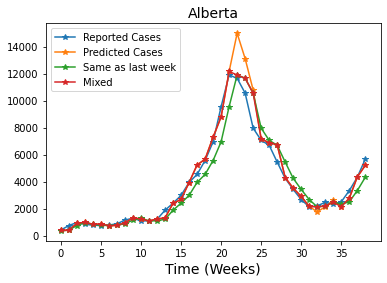

MAPE predictions:  10.608368554682338
MAPE same:  17.638503873432224
MAPE mixed:  7.886526032880751
Week 2


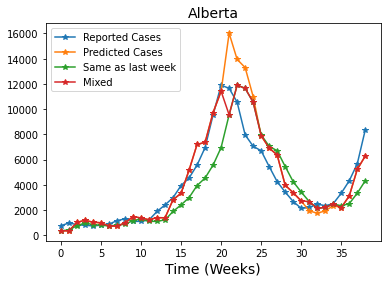

MAPE predictions:  23.74710904864172
MAPE same:  33.24338659020825
MAPE mixed:  20.192104233635565
Week 3


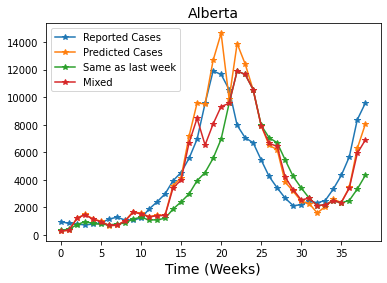

MAPE predictions:  33.77546953852011
MAPE same:  48.10227300894891
MAPE mixed:  34.357336507214484
Week 4


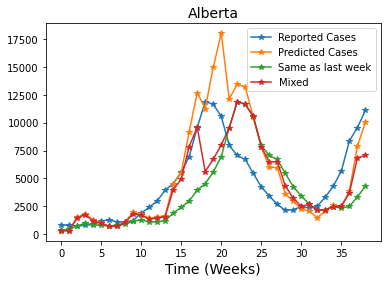

MAPE predictions:  47.38245129841912
MAPE same:  63.760054707846045
MAPE mixed:  46.12552720488667
Week 1


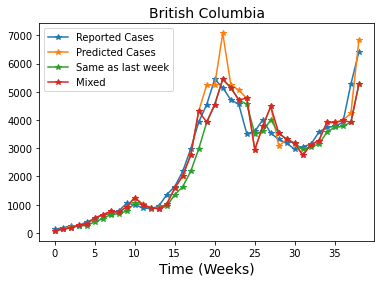

MAPE predictions:  12.3074461946301
MAPE same:  11.929052941844565
MAPE mixed:  11.164233753976681
Week 2


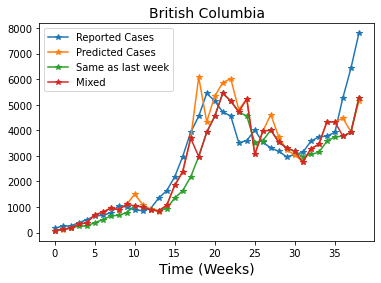

MAPE predictions:  22.286556992133786
MAPE same:  20.55198704477398
MAPE mixed:  18.47599550924033
Week 3


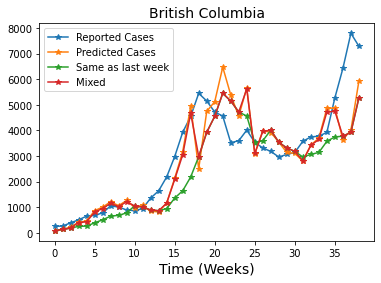

MAPE predictions:  23.587287254575532
MAPE same:  25.629665443371938
MAPE mixed:  22.514577835753457
Week 4


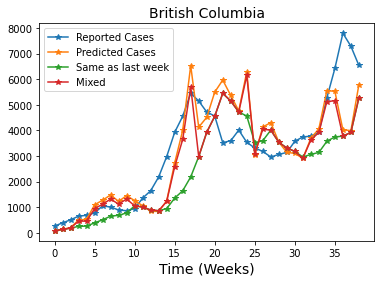

MAPE predictions:  27.738388930801158
MAPE same:  31.38192067804756
MAPE mixed:  25.63930162507516
Week 1


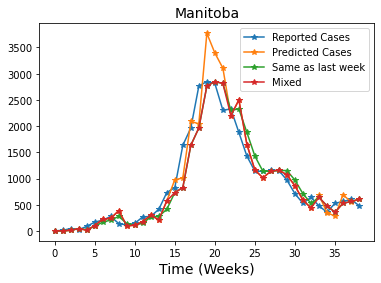

MAPE predictions:  20.173442014029582
MAPE same:  21.469441027102736
MAPE mixed:  19.225013983862144
Week 2


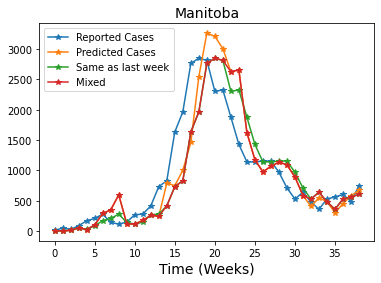

MAPE predictions:  34.713162301188405
MAPE same:  37.34099757889982
MAPE mixed:  36.82317999392112
Week 3


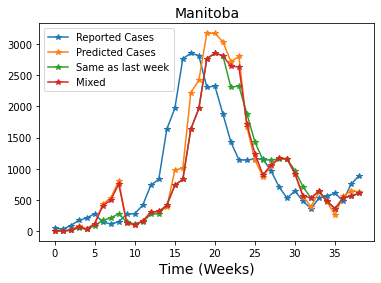

MAPE predictions:  48.42909938518028
MAPE same:  50.384751835028325
MAPE mixed:  50.01644464429319
Week 4


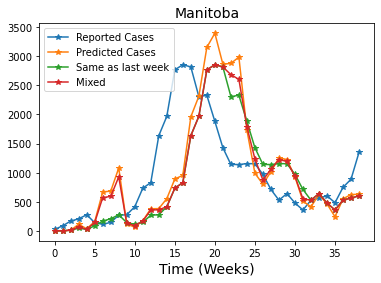

MAPE predictions:  63.976647950062514
MAPE same:  62.09577669786482
MAPE mixed:  60.765217011793396
Week 1


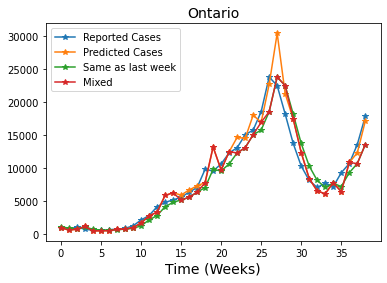

MAPE predictions:  13.997859722278754
MAPE same:  16.473152641423198
MAPE mixed:  14.092204856722502
Week 2


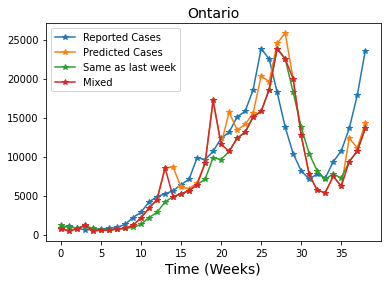

MAPE predictions:  29.34102550494204
MAPE same:  29.590911469723117
MAPE mixed:  28.918281239970135
Week 3


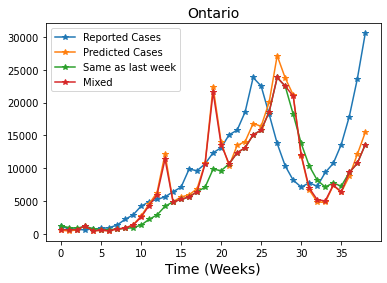

MAPE predictions:  44.00542492852225
MAPE same:  42.26162147398707
MAPE mixed:  42.215354871298885
Week 4


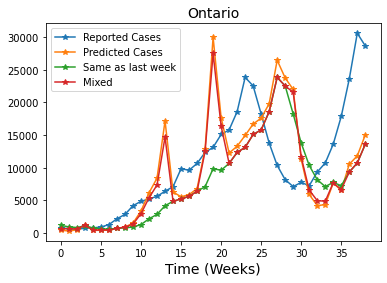

MAPE predictions:  59.418800099877615
MAPE same:  53.734754615038675
MAPE mixed:  55.52857483769552
Week 1


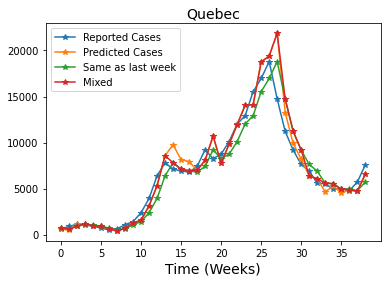

MAPE predictions:  14.861548372748967
MAPE same:  16.69836779642943
MAPE mixed:  13.729092988761217
Week 2


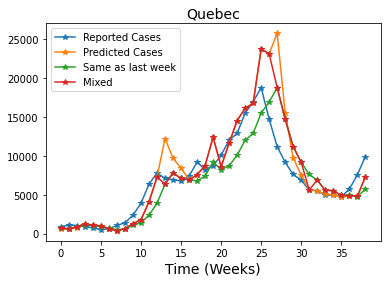

MAPE predictions:  26.633213057875633
MAPE same:  27.70893964372608
MAPE mixed:  22.961120325386613
Week 3


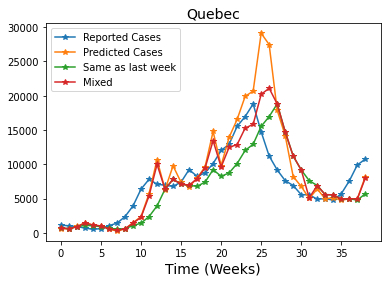

MAPE predictions:  34.102837393405814
MAPE same:  37.29845082138777
MAPE mixed:  33.03606595573214
Week 4


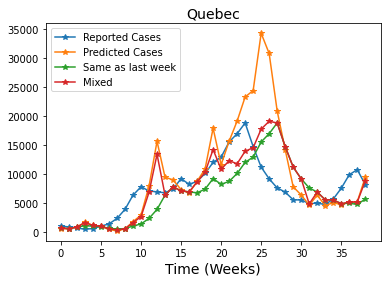

MAPE predictions:  51.673007006142285
MAPE same:  45.831462079149425
MAPE mixed:  39.24658757728185
Week 1


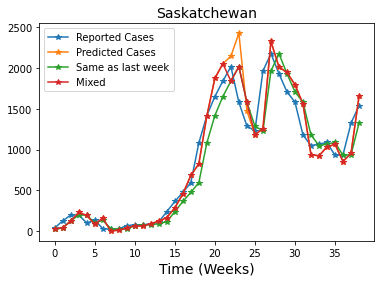

MAPE predictions:  15.088958472390145
MAPE same:  18.92786401695015
MAPE mixed:  14.475503602113818
Week 2


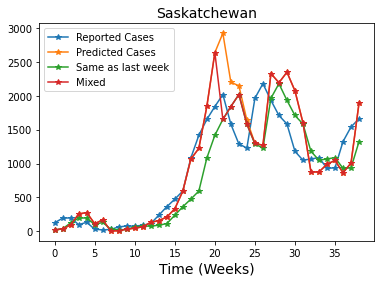

MAPE predictions:  31.465525745433617
MAPE same:  33.01085307420661
MAPE mixed:  28.901421257209666
Week 3


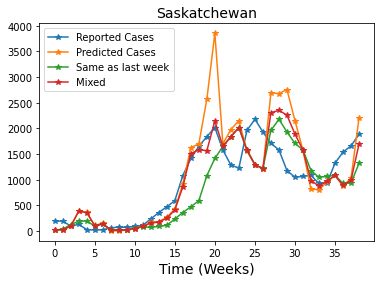

MAPE predictions:  42.4033148119626
MAPE same:  43.084055749234395
MAPE mixed:  32.28899321348976
Week 4


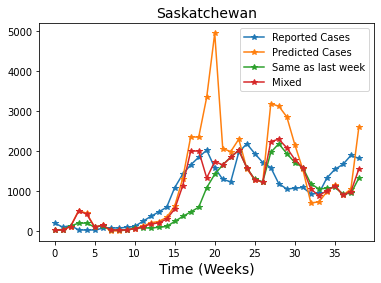

MAPE predictions:  60.537488213589995
MAPE same:  48.97862699551813
MAPE mixed:  38.479610272600226


In [11]:
# Create the graphs and compare the different methods in term of MAPE
start_week=10

for region in all_regions:
    for i in range(4):
        print('Week ' + str(i+1))
        real_cases = np.array(results_dict[region]['Real_Cases_W_'+str(i+1)])[start_week:-4]
        predicted_cases = np.array(results_dict[region]['Predicted_Cases_W_'+str(i+1)])[start_week:-4]
        same_as_last = np.array(results_dict[region]['Sames_as_last_W_'+str(i+1)])[start_week:-4]
        mixed = np.array(results_dict[region]['Mixed_Cases_W_'+str(i+1)])[start_week:-4]

        plt.figure(figsize=(6,4))
        plt.title(region, fontsize=14)
        plt.plot(real_cases, '-*')
        plt.plot(predicted_cases, '-*')
        plt.plot(same_as_last, '-*')
        plt.plot(mixed, '-*')
        plt.legend(['Reported Cases', 'Predicted Cases', 'Same as last week', 'Mixed'])
        plt.xlabel('Time (Weeks)', fontsize=14)

        plt.show()

        mape_predicted, _ = MAPE(real_cases[start_week:-4], 
                                 predicted_cases[start_week:-4], np.mean)
        mape_same, _ = MAPE(real_cases[start_week:-4], 
                            same_as_last[start_week:-4], np.mean)
        mape_mixed, _ = MAPE(real_cases[start_week:-4], mixed[start_week:-4], np.mean)

        print('MAPE predictions: ', mape_predicted)
        print('MAPE same: ', mape_same)
        print('MAPE mixed: ', mape_mixed)